# Imports

In [290]:
import sys

import numpy as np
np.set_printoptions(linewidth=150)

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['figure.dpi'] = 600

from scipy.optimize import curve_fit

In [54]:
from lattviz import draw_lattice_2d

# Fit functions for radiation profiles

In [55]:
# Fitting functions
def inverse_square(x, k):
    return k * np.power(x, -2)

def inverse_square_bg(x, k, y_0):
    return y_0 + k * np.power(x, -2)

def inverse_exp(x, k, b):
    return k * np.exp(-b*x)

def gaussian(x, A, b, c):
    return A * np.exp(-(x-b)**2/(2*c))

def mwbm(x, a, b):
    return (2/np.pi)**0.5 * (x+b)**2/a**3 * np.exp(-(x-b)**2/(2*a**2))

# Schemes for Lattice Boltzmann Methods

In [134]:
n = 2
NL = 8

cxs = []
cys = []
czs = []

if n == 2:
    if NL == 8:
        idxs_dir = [0, 4,  1,  5, 2,  6,  3,  7]
        cxs = [1, 0, -1,  0, 1, -1, -1,  1]
        cys = [0, 1,  0, -1, 1,  1, -1, -1]
        
        boundary_idxs_left = [2, 5, 6]
        boundary_idxs_right = [0, 4, 7]
        boundary_idxs_top = [1, 4, 5]
        boundary_idxs_bottom = [3, 6, 7]
    elif NL == 16:
        idxs_dir = [0, 4,  1,  5, 2,  6,  3,  7, 8, 9, 10, 11, 12, 13, 14, 15]
        cxs = [1, 0, -1,  0, 1, -1, -1,  1, 2, 1, -1, -2, -2, -1,  1,  2]
        cys = [0, 1,  0, -1, 1,  1, -1, -1, 1, 2,  2,  1, -1, -2, -2, -1]

        boundary_idxs_left = [2, 5, 6, 11, 12]
        boundary_idxs_right = [0, 4, 7, 8, 15]
        boundary_idxs_top = [1, 4, 5, 9, 10]
        boundary_idxs_bottom = [3, 6, 7, 13, 14]

    # Array positions of the boundaries
    # boundary_pos = [
    #     [slice(0, NY, 1),    slice(0, 1, 1)    ], # left
    #     [slice(0, NY, 1),    slice(NX-1, NX, 1)], # right
    #     [slice(0, 1, 1),     slice(0, NX, 1)   ], # top
    #     [slice(NY-1, NY, 1), slice(0, NX, 1)   ], # bottom
    # ]
    
    boundary_idxs = [boundary_idxs_left, boundary_idxs_right, boundary_idxs_top, boundary_idxs_bottom]
elif n == 3:
    if NL == 18:
        idxs_dir = [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
        cxs = [-1,  0,  0, -1, -1, -1, -1,  0,  0, 1,  0,  0,  1,  1,  1,  1,  0,  0]
        cys = [ 0, -1,  0, -1,  1,  0,  0, -1, -1, 0,  1,  0,  1, -1,  0,  0,  1,  1]
        czs = [ 0,  0, -1,  0,  0, -1,  1, -1,  1, 0,  0,  1,  0,  0,  1, -1,  1, -1]

assert len(cxs) == NL
assert len(cys) == NL

if n >= 3:
    assert len(czs) == NL

# Normalization - uncertain about the usefulness
# for i in range(NL):
#     mag_c_i = (cxs[i]**2 + cys[i]**2)**0.5
#     cxs[i] /= mag_c_i
#     cys[i] /= mag_c_i

print(cxs)
print(cys)

print("-----")

[1, 0, -1, 0, 1, -1, -1, 1]
[0, 1, 0, -1, 1, 1, -1, -1]
-----


# Simulation steps

In [308]:
# Source boundary conditions
def emit(xf, sources):
    for source_position, source_value in sources:
        if isinstance(source_value, list):
            # If the source data is a list, we try to interpret it as a directional source
            if len(source_value) == xf.shape[2]:
                xf[source_position] = source_value
            else:
                raise ValueError(f"Source value list of length {len(source_value)}, instead of expected {xf.shape[2]}.")
        else:
            # If the source data is constant, we interpret it as an isotropic source
            xf[source_position, :] = source_value
    
    return xf

# More general (wall) boundary conditons
def apply_wall_boundary_conditions(xi, boundary_conditions="absorb", bc_values=None):
    xf = np.array(xi, copy=True)

    if boundary_conditions == "periodic":
        # Radiation travelling leftwards into the left wall is transported to the right wall
        xf[:, -1, boundary_idxs_left] = xi[:, 0, boundary_idxs_left]
        # xf[:, 0, boundary_idxs_left] = 0
        # Radiation travelling rightwards into the right wall is transported to the left wall
        xf[:, 0, boundary_idxs_right] = xi[:, -1, boundary_idxs_right]
        # xf[:, -1, boundary_idxs_right] = 0
        # Radiation travelling upwards into the top wall is transported to the bottom wall
        xf[0, :, boundary_idxs_top] = xi[-1, :, boundary_idxs_top]
        # xf[-1, :, boundary_idxs_top] = 0
        # Radiation travelling downwards into the bottom wall is transported to the top wall
        xf[-1, :, boundary_idxs_bottom] = xi[0, :, boundary_idxs_bottom]
        # xf[0, :, boundary_idxs_bottom] = 0

        # @TODO - corners satisfy two of these boundary conditions
    elif boundary_conditions == "absorb":
        # x-left
        xf[:, 0, boundary_idxs_left] = xi[:, 1, boundary_idxs_left]
        # x-right
        xf[:, -1, boundary_idxs_right] = xi[:, -2, boundary_idxs_right]
        # y-top
        xf[0, :, boundary_idxs_top] = xi[1, :, boundary_idxs_top]
        # y-bottom
        xf[-1, :, boundary_idxs_bottom] = xi[-2, :, boundary_idxs_bottom]
    elif isinstance(boundary_conditions, list):
        if len(boundary_conditions) != 4:
            raise ValueError("Please specify boundary condition for all boundaries when using custom boundary conditions!")
        
        for b, boundary_condition in enumerate(boundary_conditions):
            bc_type = boundary_condition[0]

            if bc_type == "dirichlet": # Fix the value at the boundary
                bc_val = boundary_condition[1]
                
                if b == 0:
                    xf[:, 0, boundary_idxs_left] = bc_val
                elif b == 1:
                    xf[:, -1, boundary_idxs_right] = bc_val
                elif b == 2:
                    xf[0, :, boundary_idxs_top] = bc_val
                elif b == 3:
                    xf[-1, :, boundary_idxs_bottom] = bc_val
            elif bc_type == "neumann": # Fix the gradient at the boundary - here, by fixing the backward gradient
                bc_grad = boundary_condition[1]
                
                if b == 0:
                    xf[:, 0, boundary_idxs_left] = bc_grad + xi[:, 1, boundary_idxs_left]
                elif b == 1:
                    xf[:, -1, boundary_idxs_right] = bc_grad + xi[:, -2, boundary_idxs_right]
                elif b == 2:
                    xf[0, :, boundary_idxs_top] = bc_grad + xi[1, :, boundary_idxs_top]
                elif b == 3:
                    xf[-1, :, boundary_idxs_bottom] = bc_grad + xi[-2, :, boundary_idxs_bottom]
            elif bc_type == "periodic": # Treat grid as though it repeated infinitely
                if b == 0:
                    xf[:, 0, boundary_idxs_left] = xi[:, -1, boundary_idxs_left]
                elif b == 1:
                    xf[:, -1, boundary_idxs_right] = xi[:, 0, boundary_idxs_right]
                elif b == 2:
                    xf[0, :, boundary_idxs_top] = xi[-1, :, boundary_idxs_top]
                elif b == 3:
                    xf[-1, :, boundary_idxs_bottom] = xi[0, :, boundary_idxs_bottom]

    return xf

# Interior boundary conditions
def apply_interior_boundary_conditions(xi, boundary_conditions=None, region_mask=None, bc_values=None):
    xf = np.array(xi, copy=True)

    if boundary_conditions == "dirichlet": # Fix the value in the interior region
        xf[region_mask] = bc_values

    return xf
    
# Propagation function
def propagate(xi, number_density, redist_coeff):
    NX = np.shape(xi)[1]
    NY = np.shape(xi)[0]

    if isinstance(number_density, (int, float)):
        number_density = np.ones((NY, NX)) * number_density
    
    xf = np.zeros_like(xi)

    for dir_i, i_dir in enumerate(idxs_dir):
        nl = i_dir
        cy = cys[i_dir]
        cx = cxs[i_dir]

        for j in range(NY):
            for i in range(NX):
                l_src = xi[j, i, nl]

                dir_i_next = (dir_i+1) % NL
                dir_i_prev = (dir_i-1) % NL
                nl_next = idxs_dir[dir_i_next]
                nl_prev = idxs_dir[dir_i_prev]

                cx_next = cxs[nl_next]
                cy_next = cys[nl_next]
                cx_prev = cxs[nl_prev]
                cy_prev = cys[nl_prev]

                # @TODO - correctly adjust streamed amount based on speed
                l_stream = l_src
                if False:
                    v = (cx**2 + cy**2)**0.5/2**0.5
                    l_stream = l_src * v
                    xf[j, i, nl] += l_src - l_stream

                # Calculate optical depth for main streaming
                dt = 1
                dr = np.sqrt(cx**2 + cy**2) * dt
                sigma = 1
                nij = number_density[j, i]
                tau = sigma * nij * dr

                # Stream the value to the next lattice in the same direction
                xf[(j + cy) % NY, (i + cx) % NX, nl] += redist_coeff * l_stream * np.exp(-tau)

                # if np.sum(l_src) > 0:
                #     print(f"lattice indices: {nl_prev} {nl} {nl_next}")
                #     print(f"lattice directions - (x,y) order: {cx_prev, cy_prev} {cx, cy} {cx_next, cy_next}")
                #     print(f"lattice directions - (y,x) order: {cy_prev, cx_prev} {cy, cx} {cy_next, cx_next}")
                #     print(f"this lattice point: {j, i}, {nl}")
                #     print(f"the carrier lattice dest: {(j + cy) % NY, (i + cx) % NX}, {nl}")
                #     print(f"the next lattice dest: {(j + cy_next) % NY, (i + cx_next) % NX}, {nl_next}")
                #     print(f"the prev lattice dest: {(j + cy_prev) % NY, (i + cx_prev) % NX}, {nl_prev}")
                #     print("this lattice has:", l_src)
                #     print("transferring the following amount to the carrier lattice dest:", redist_coeff * l_src, xf[(j + cy) % NY, (i + cx) % NX, nl])
                #     print("transferring amount to the next lattice dest:", (1-redist_coeff)/2 * l_src, xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next])
                #     print("transferring amount to the prev lattice dest:", (1-redist_coeff)/2 * l_src, xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev])

                # Redistribute the value to the next adjacent lattices in the adjacent directions - experimental
                # xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next] += (1-redist_coeff)/2 * l_stream
                # xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev] += (1-redist_coeff)/2 * l_stream

                # Redistribute the value to the next lattice in the adjacent directions
                xf[(j + cy) % NY, (i + cx) % NX, nl_next] += (1-redist_coeff)/2 * l_stream
                xf[(j + cy) % NY, (i + cx) % NX, nl_prev] += (1-redist_coeff)/2 * l_stream

                # if np.sum(l_src) > 0:
                #     xa = xf[(j + cy) % NY, (i + cx) % NX, nl]
                #     xb = xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next]
                #     xc = xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev]
                #     print(f"final result: {xc}, {xa}, {xb}")

                # if np.sum(l_src) > 0:
                #     print("-----")

    return xf

# Main simulation code

In [312]:
def simulate(
    x0,
    NX, NY,
    sources,
    number_density=0.0,
    redist_coeff=1.00,
    boundary_conditions="periodic",
    n_it=100,
    plotRealTime=False,
    plotLattViz=False,
    plot_period=10,
    color_opacity=False
):
    # Initial setup
    if x0 is None:
        x0 = np.zeros(shape=(NY, NX, NL))

    # Copy of array for simulation loop
    x_prev = np.array(x0, copy=True)
    
    # Simulation loop
    for it in range(n_it):
        # print(f"=== iteration {it+1} ===")
    
        # Copy the previous array
        x = np.array(x_prev, copy=True)
        
        # Propagate - streaming w/ redistribution
        x = propagate(x, number_density, redist_coeff)
    
        # Enforce boundary conditions - source
        if it >= 0 and sources is not None:
            x = emit(x, sources)

        if it == 0 and plotRealTime:
            plt.imshow(np.sum(x[::-1, :], axis=2), cmap="magma", vmin=0)
            plt.colorbar()

            plt.pause(1E-4)
            plt.cla()

        # Enforce boundary conditions - interior
        if hasattr(number_density, "__iter__"):
            region_mask = number_density >= 0.99
            x = apply_interior_boundary_conditions(x, boundary_conditions="dirichlet", region_mask=region_mask, bc_values=0)
    
        # Enforce boundary conditions - boundaries
        x = apply_wall_boundary_conditions(x, boundary_conditions=boundary_conditions)
        
        if x is None:
            break
        
        if plot_period < 1:
            plot_period = int(plot_period * n_it)
        
        plot_period = max(plot_period, 1)
        
        if ((plotRealTime or plotLattViz) and it % plot_period == 0) or it == n_it - 1:
            if plotRealTime or it == n_it - 1:
                xdraw = np.sum(np.copy(x[::-1, :]), axis=2)
                
                if color_opacity:
                    xdraw[number_density >= 0.99] = -1
                    
                # Reverse the y-axis because matrix indices != Cartesian coordinates
                plt.imshow(xdraw, cmap="magma")
                plt.colorbar(label="intensity")
                
                # plt.imshow(np.log(np.sum(x[::-1], axis=2)), cmap="magma", vmin=0)
                plt.colorbar(label="log(intensity)")
                
                min1 = np.min(xdraw)
                max2 = np.partition(xdraw.flatten(), -2)[-2]
                plt.clim(min1, max2)

                plt.title(f"Intensity plot @ it={it+1}")

                plt.savefig(f"frames/frame_{it}.png")

                if it < n_it - 1:
                    plt.pause(1E-4)
                    plt.cla()

            if plotLattViz:
                # LattViz automatically orients the lattice correctly - no need to reverse the y-axis
                draw_lattice_2d(x, cxs, cys, title=f"it={it+1}", filename=f"./lattviz_frames/lattviz_{str(it).zfill(4)}.png")

        x_prev = x
    
    return x

# Simulation usage

Starting simulation...


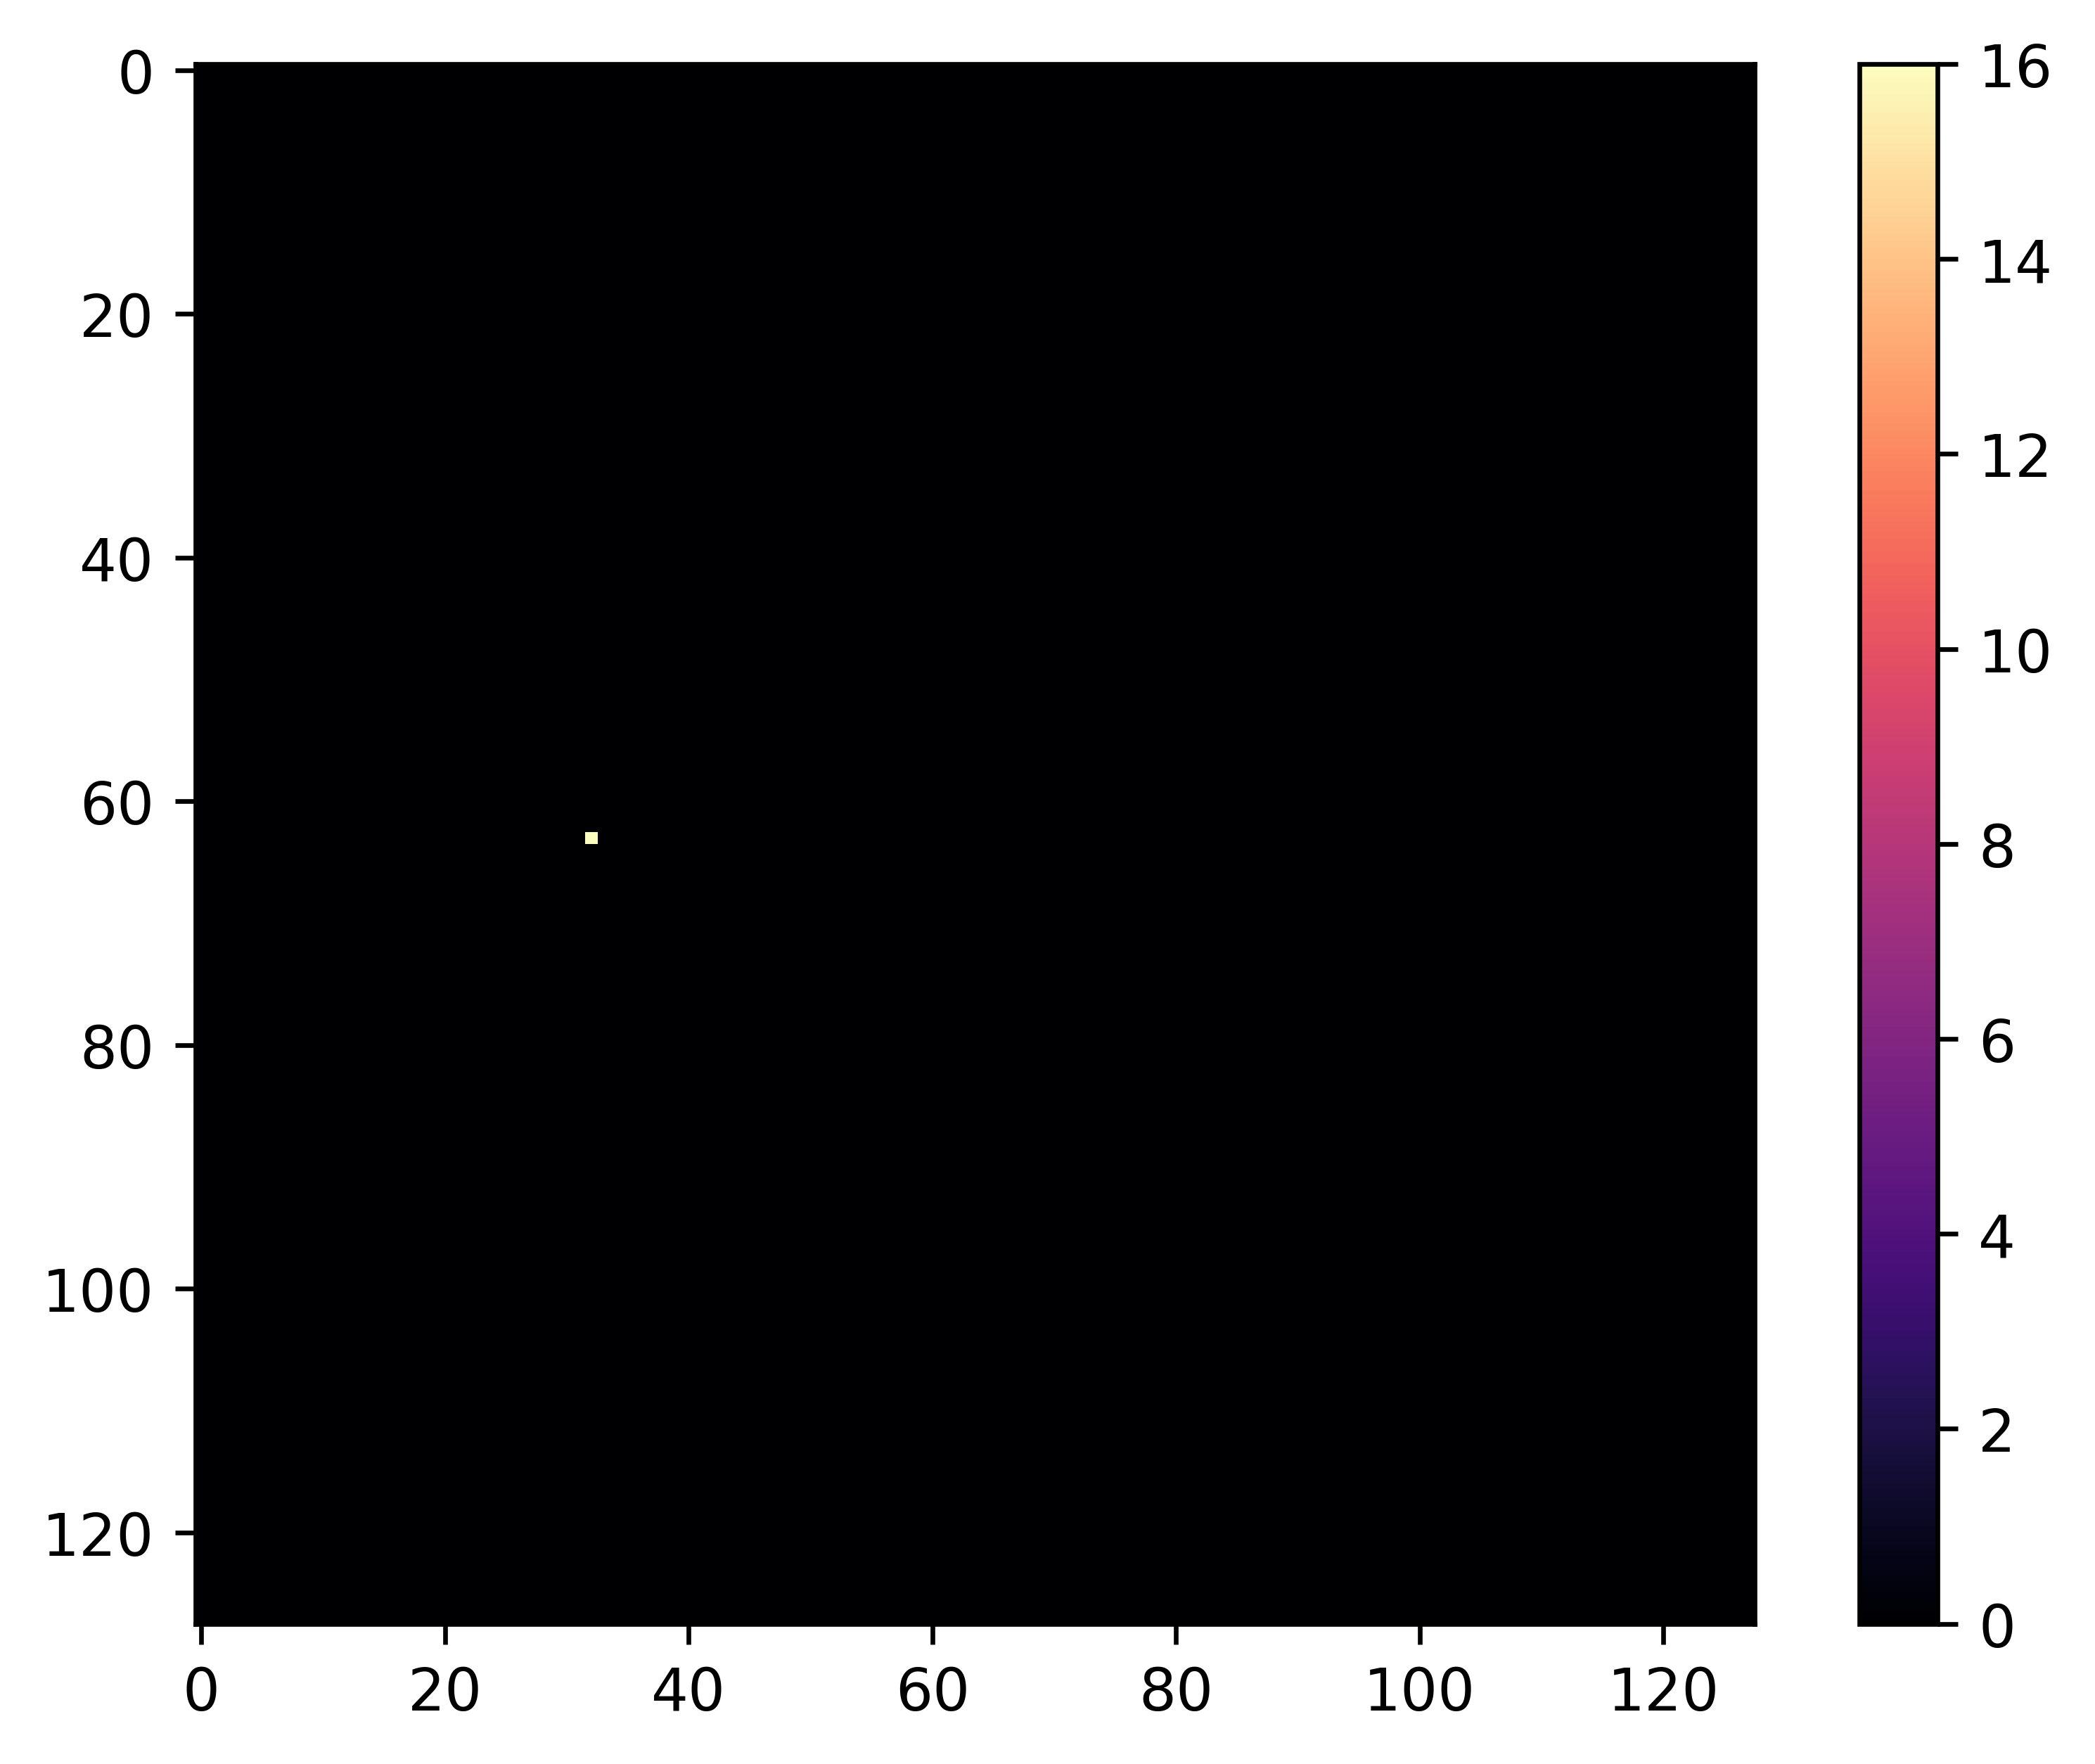

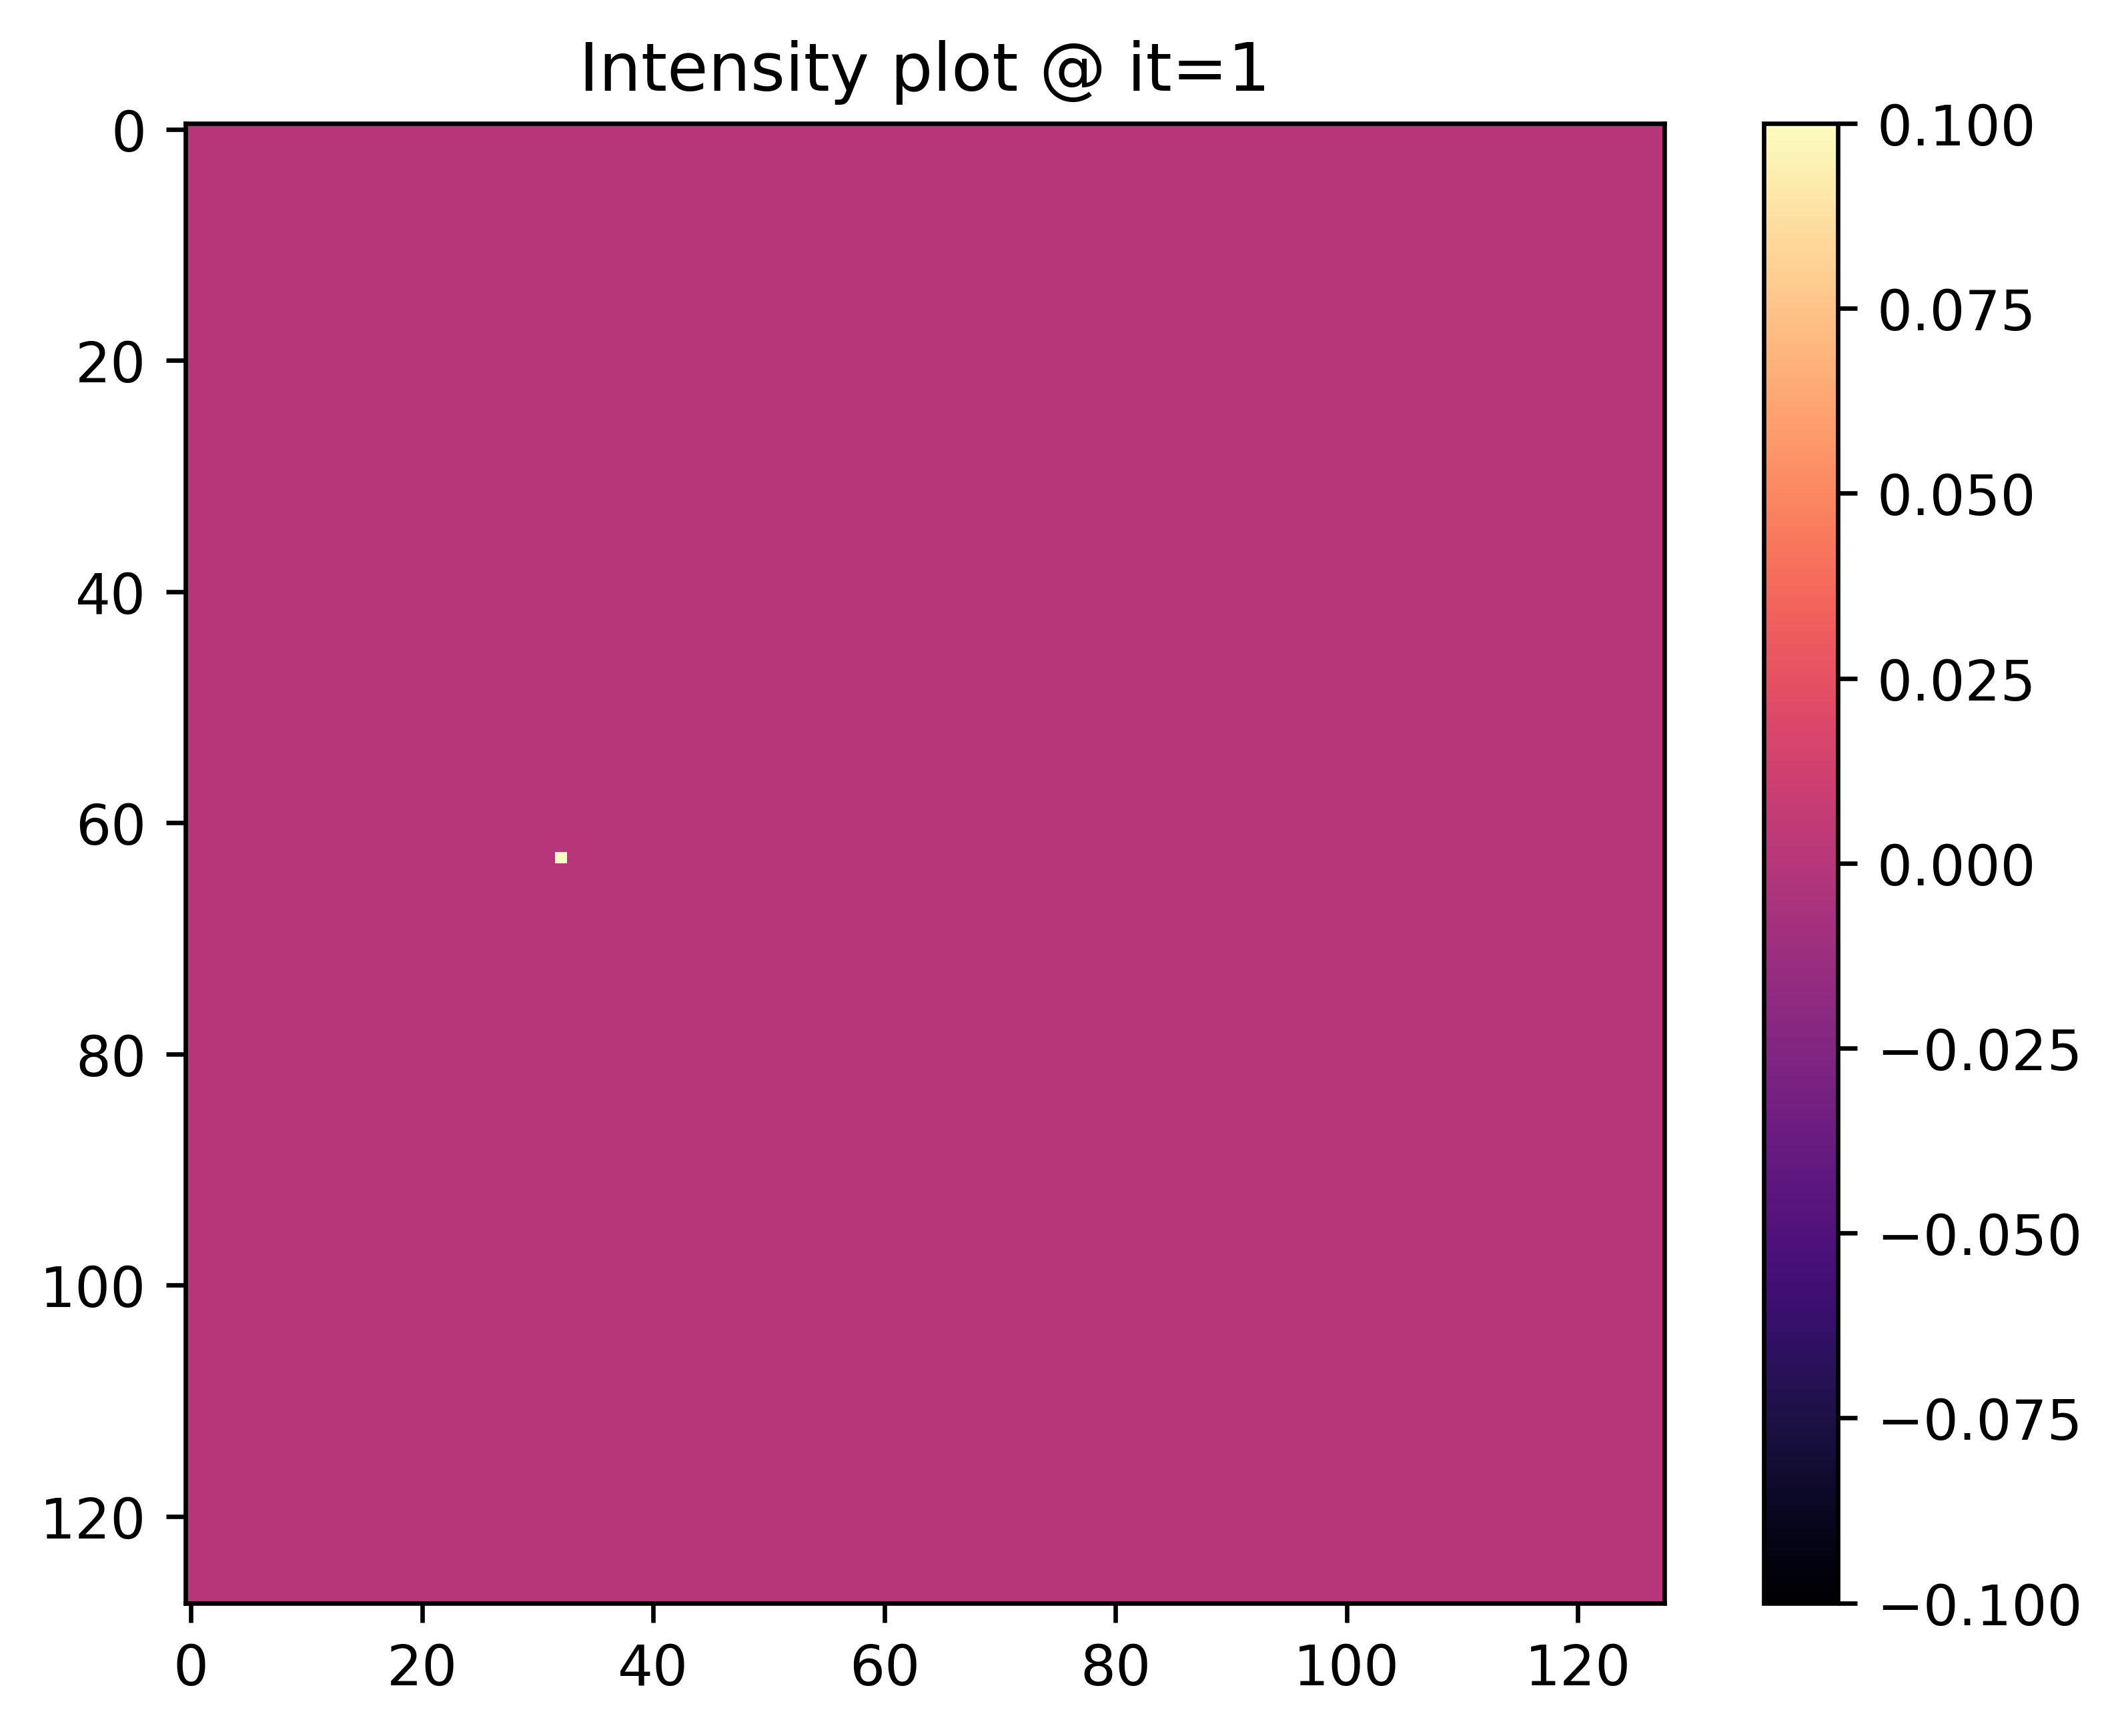

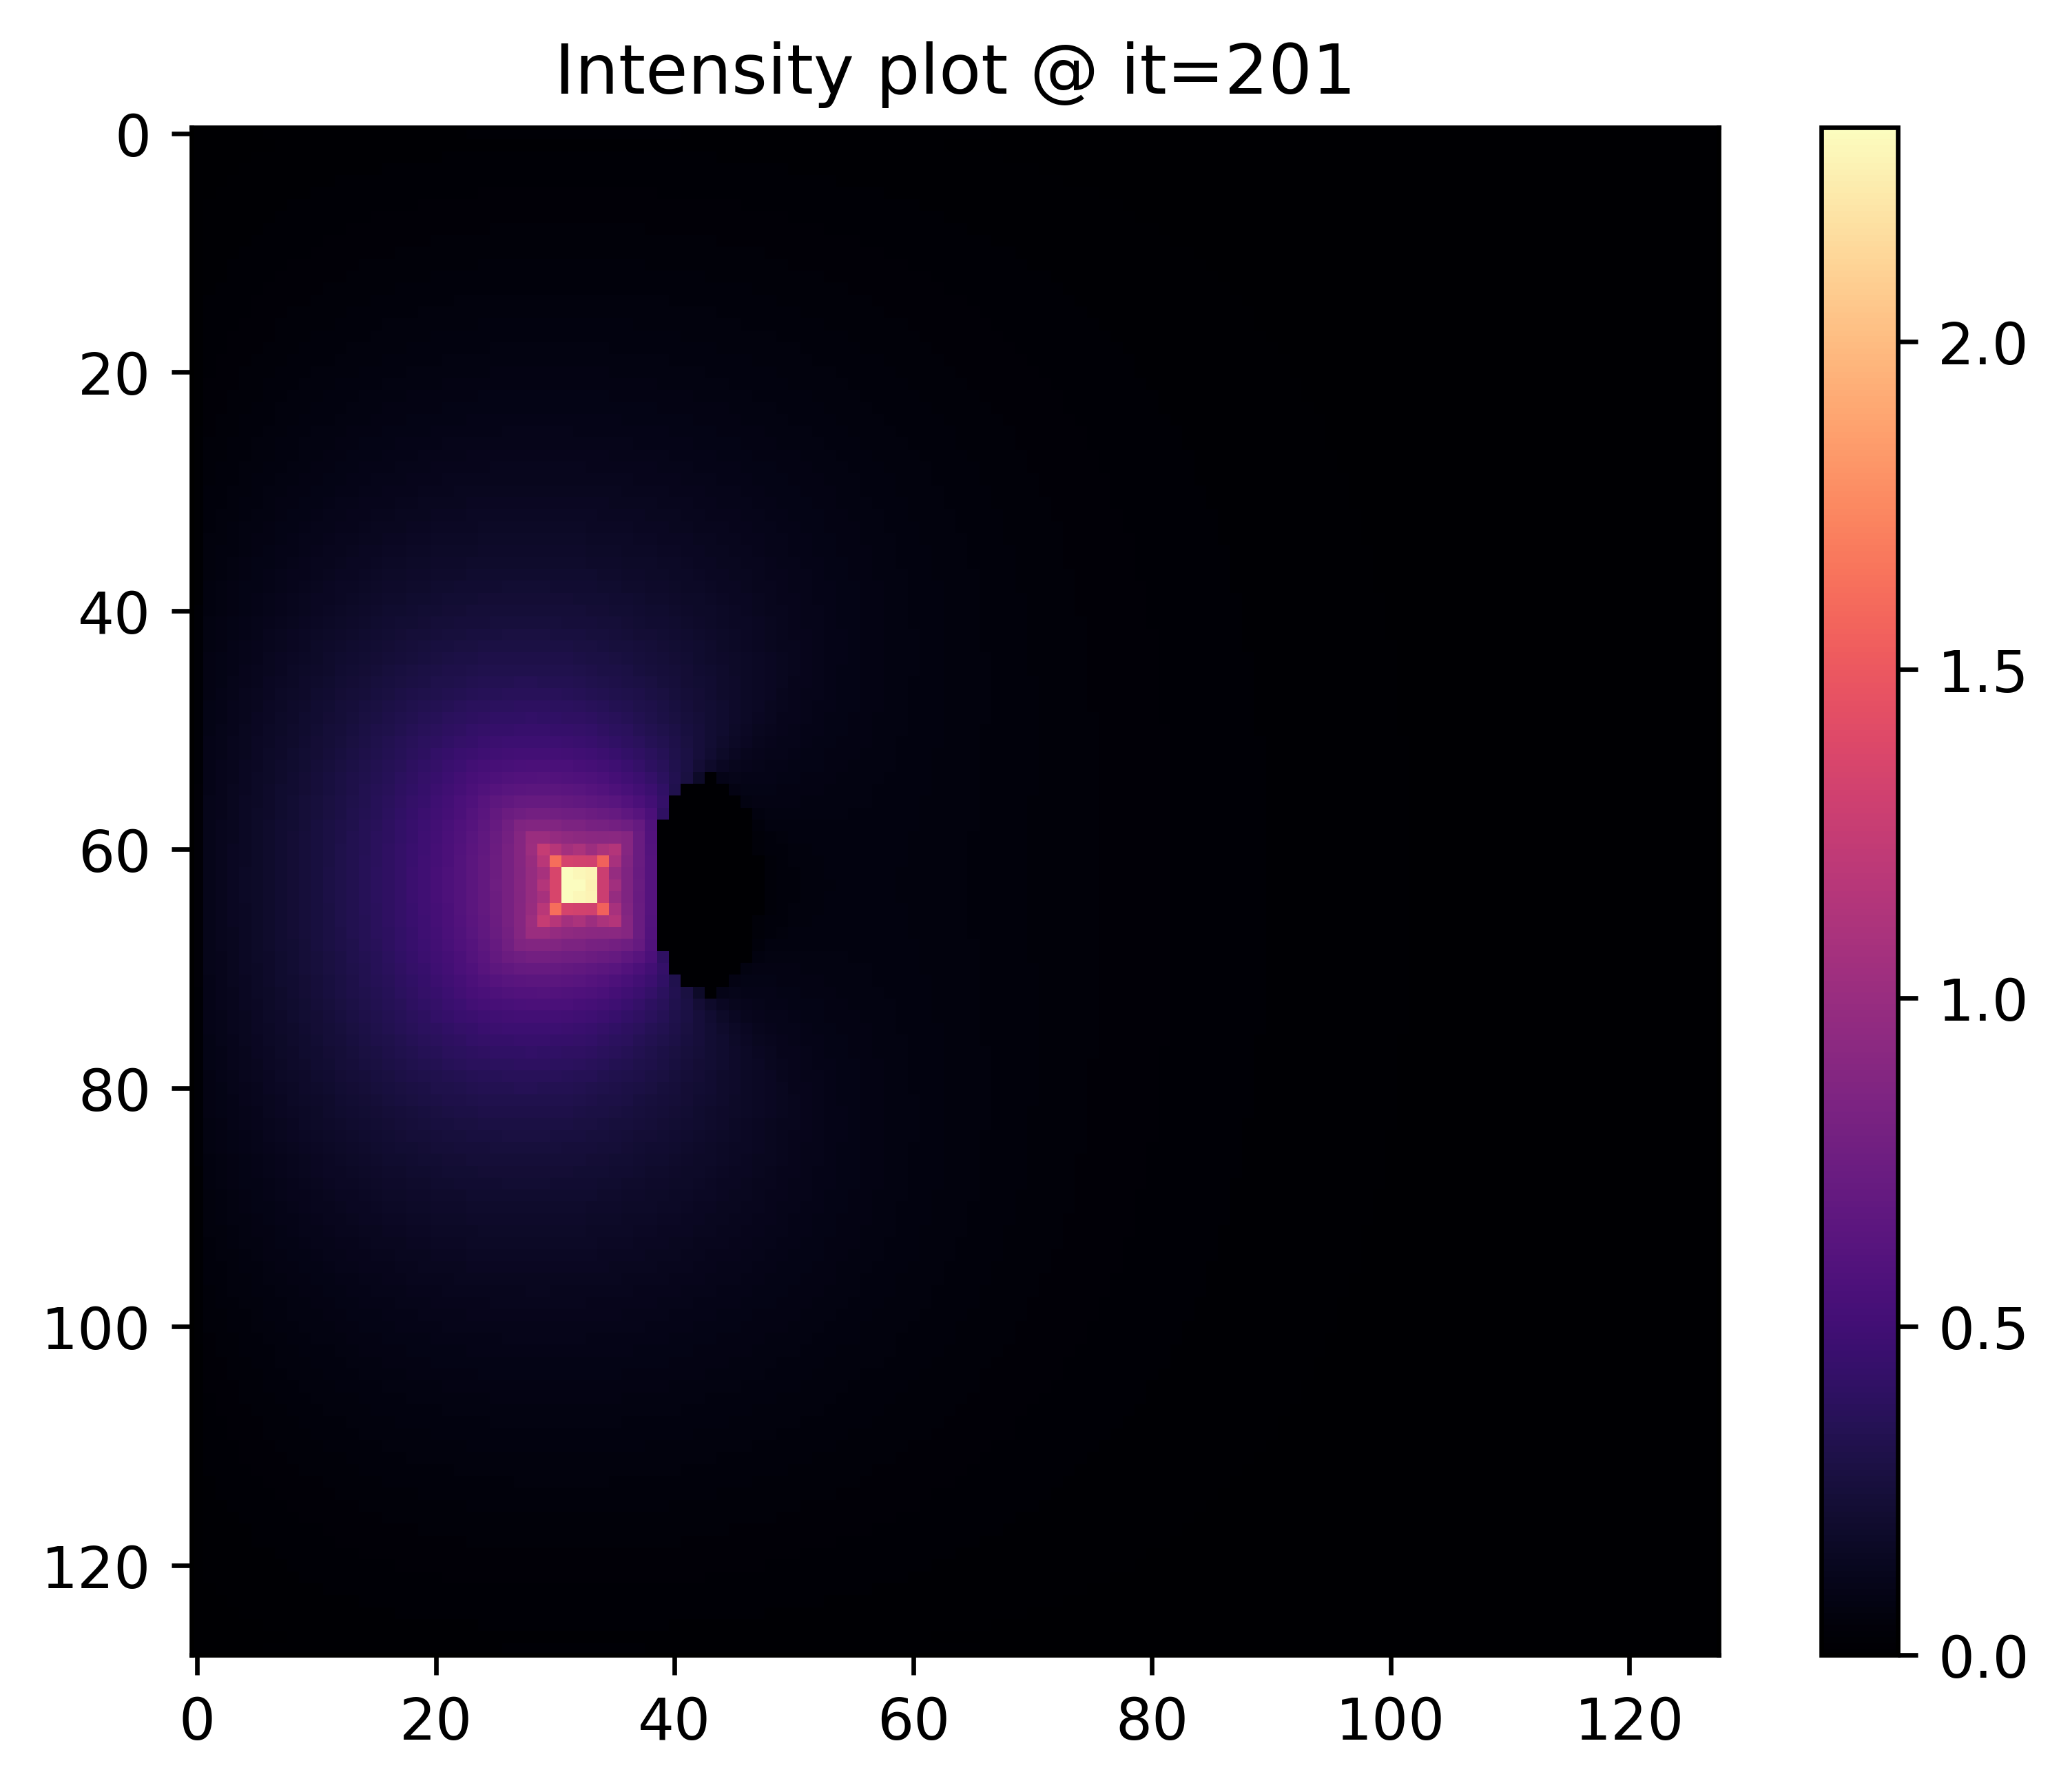

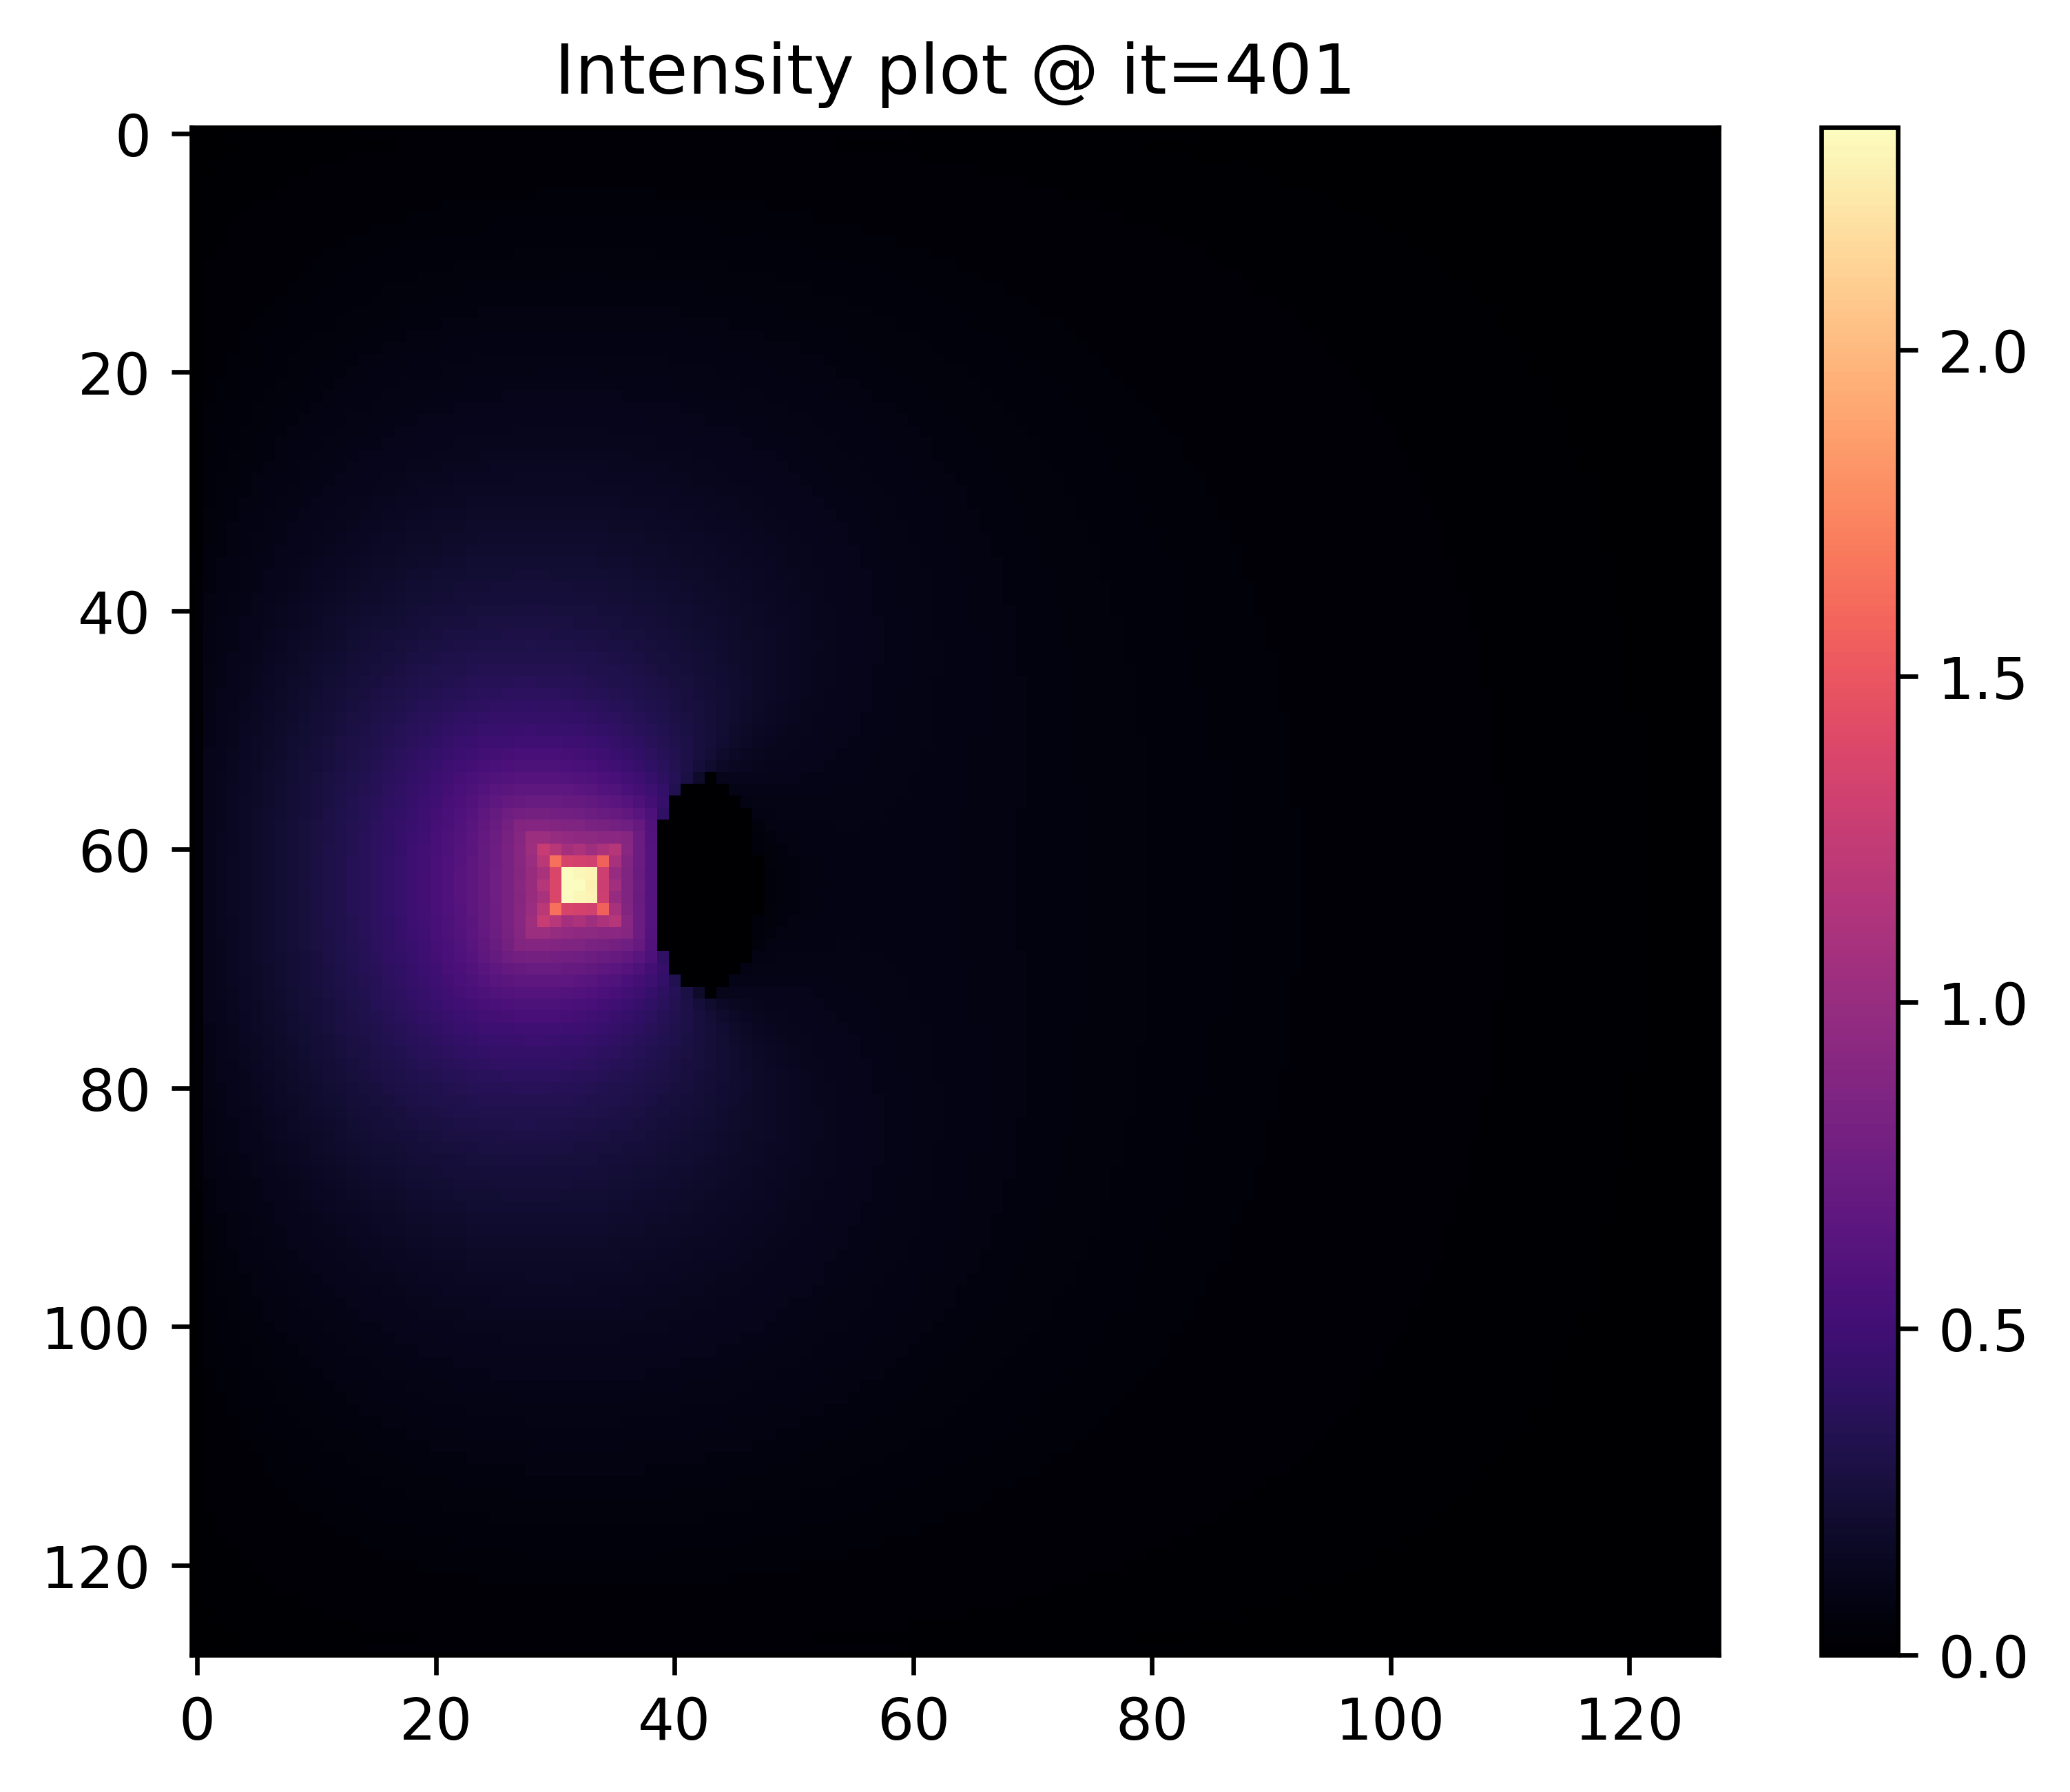

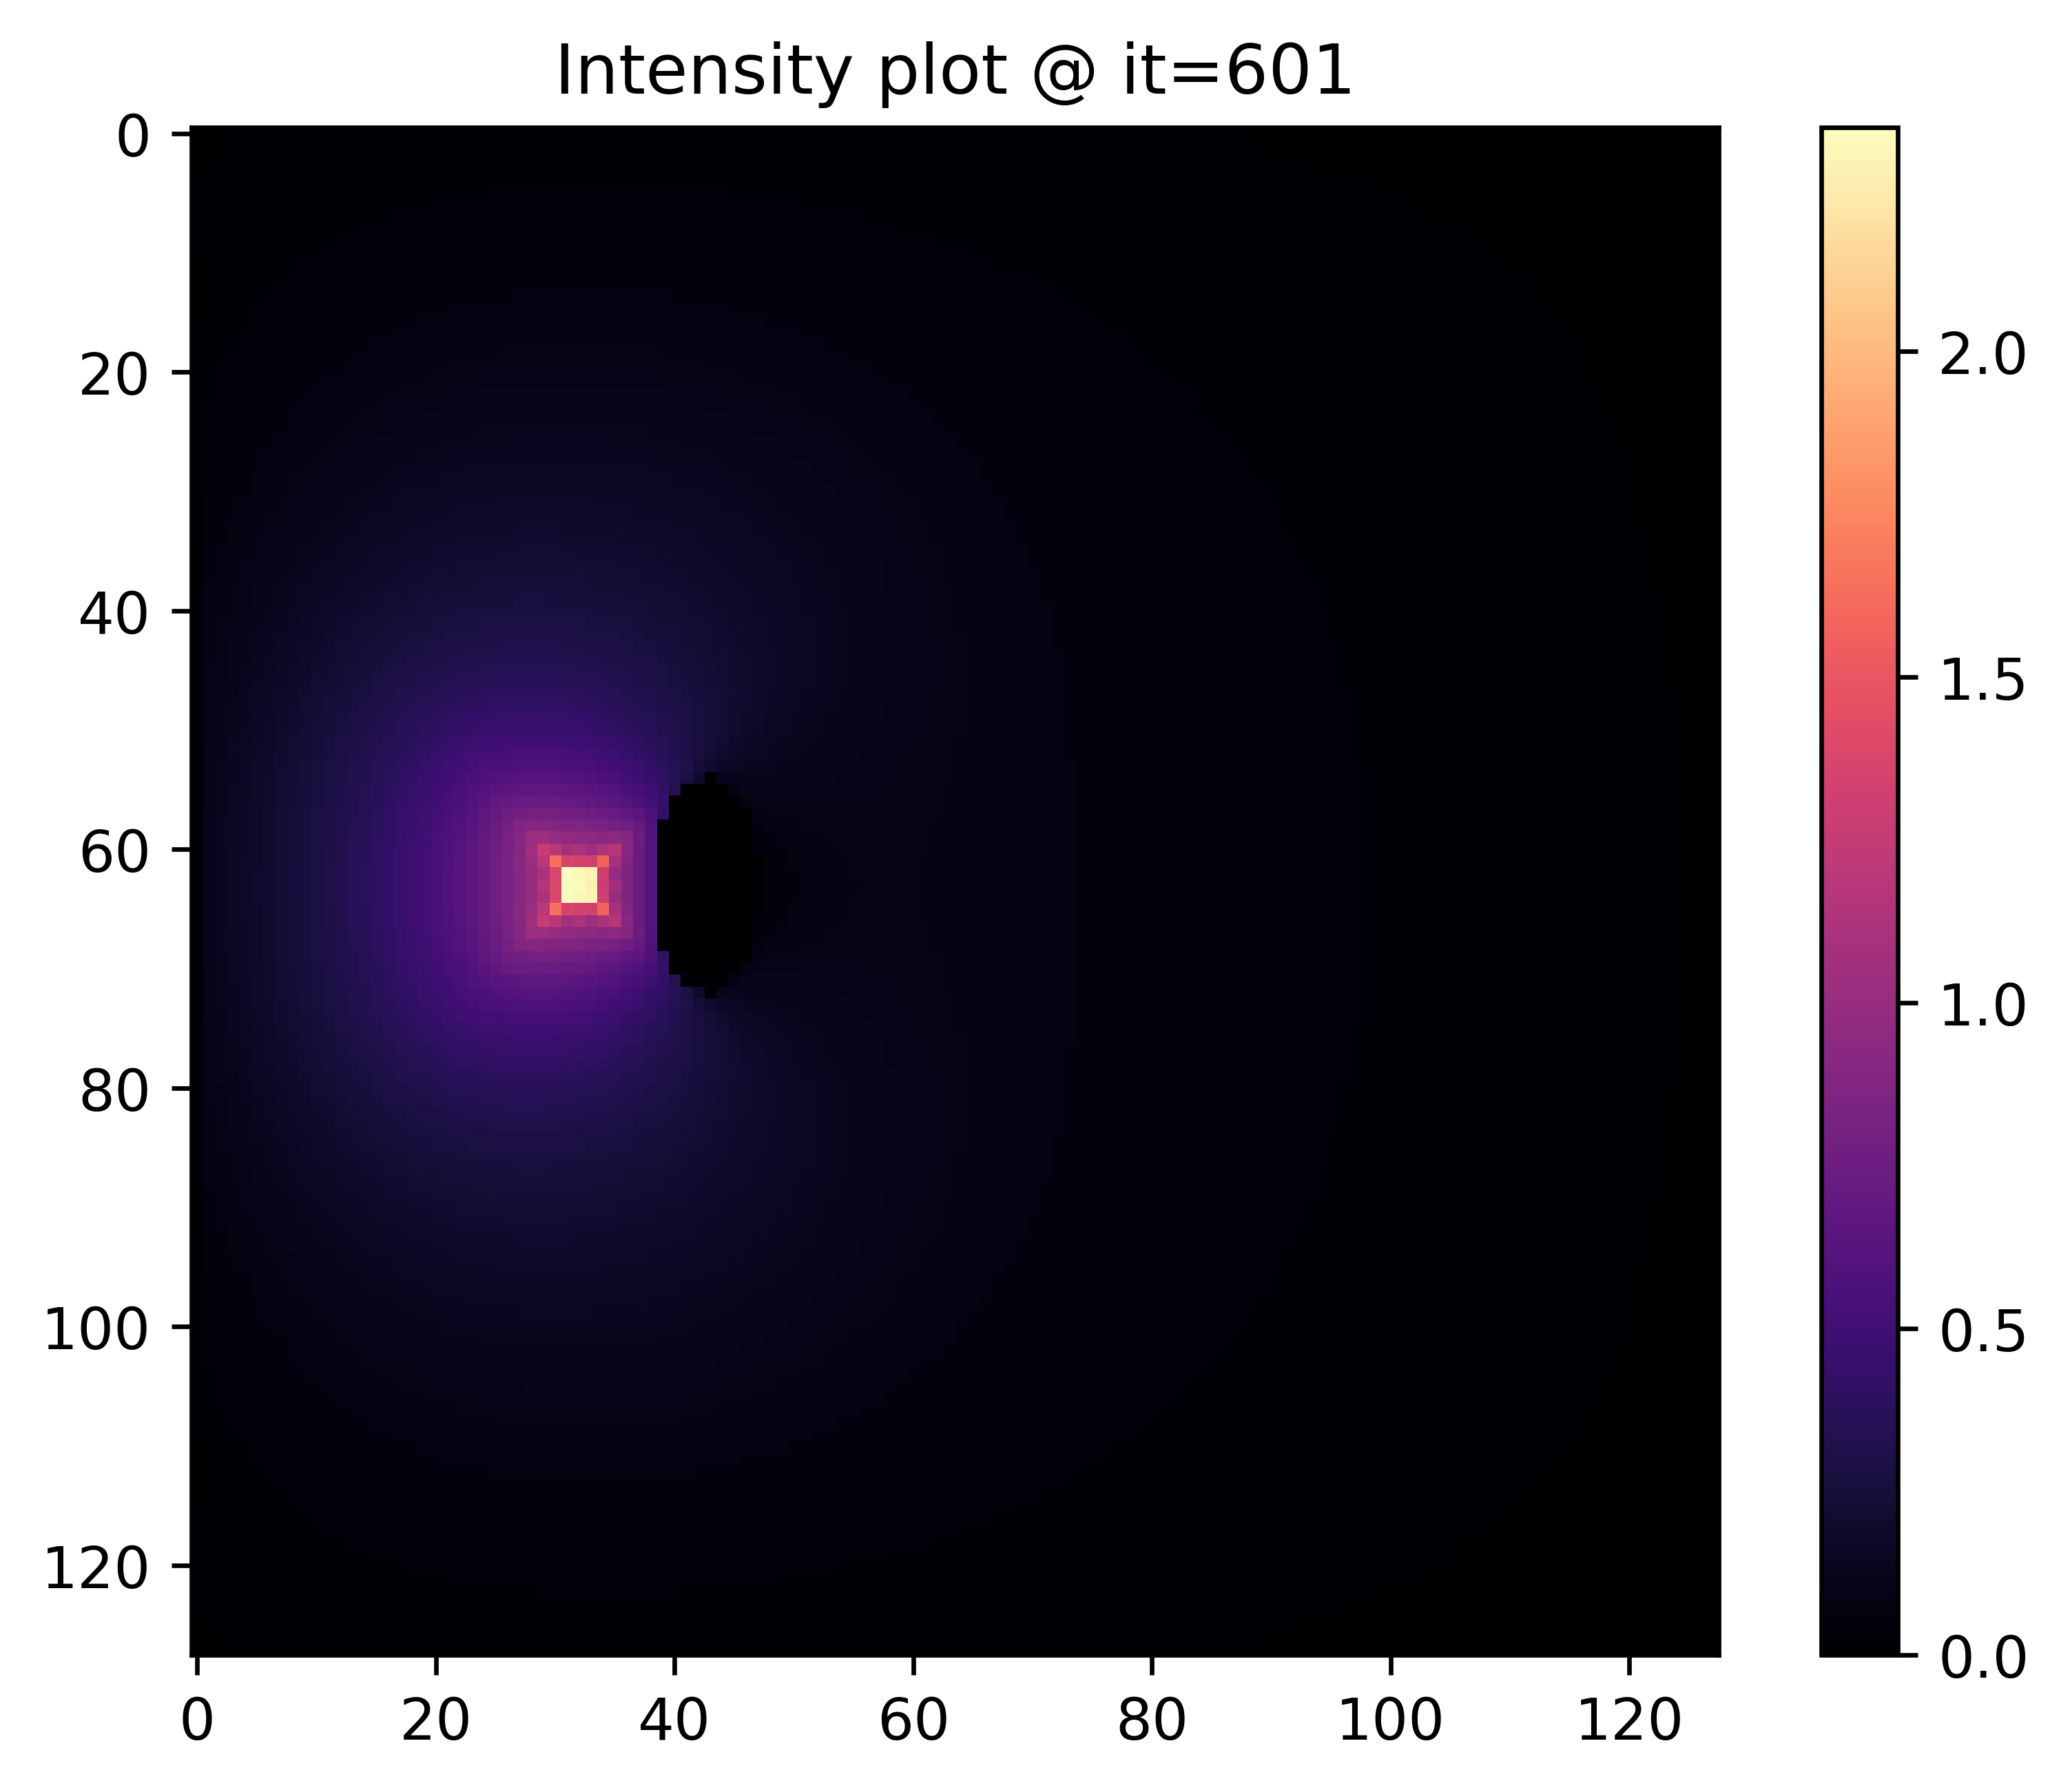

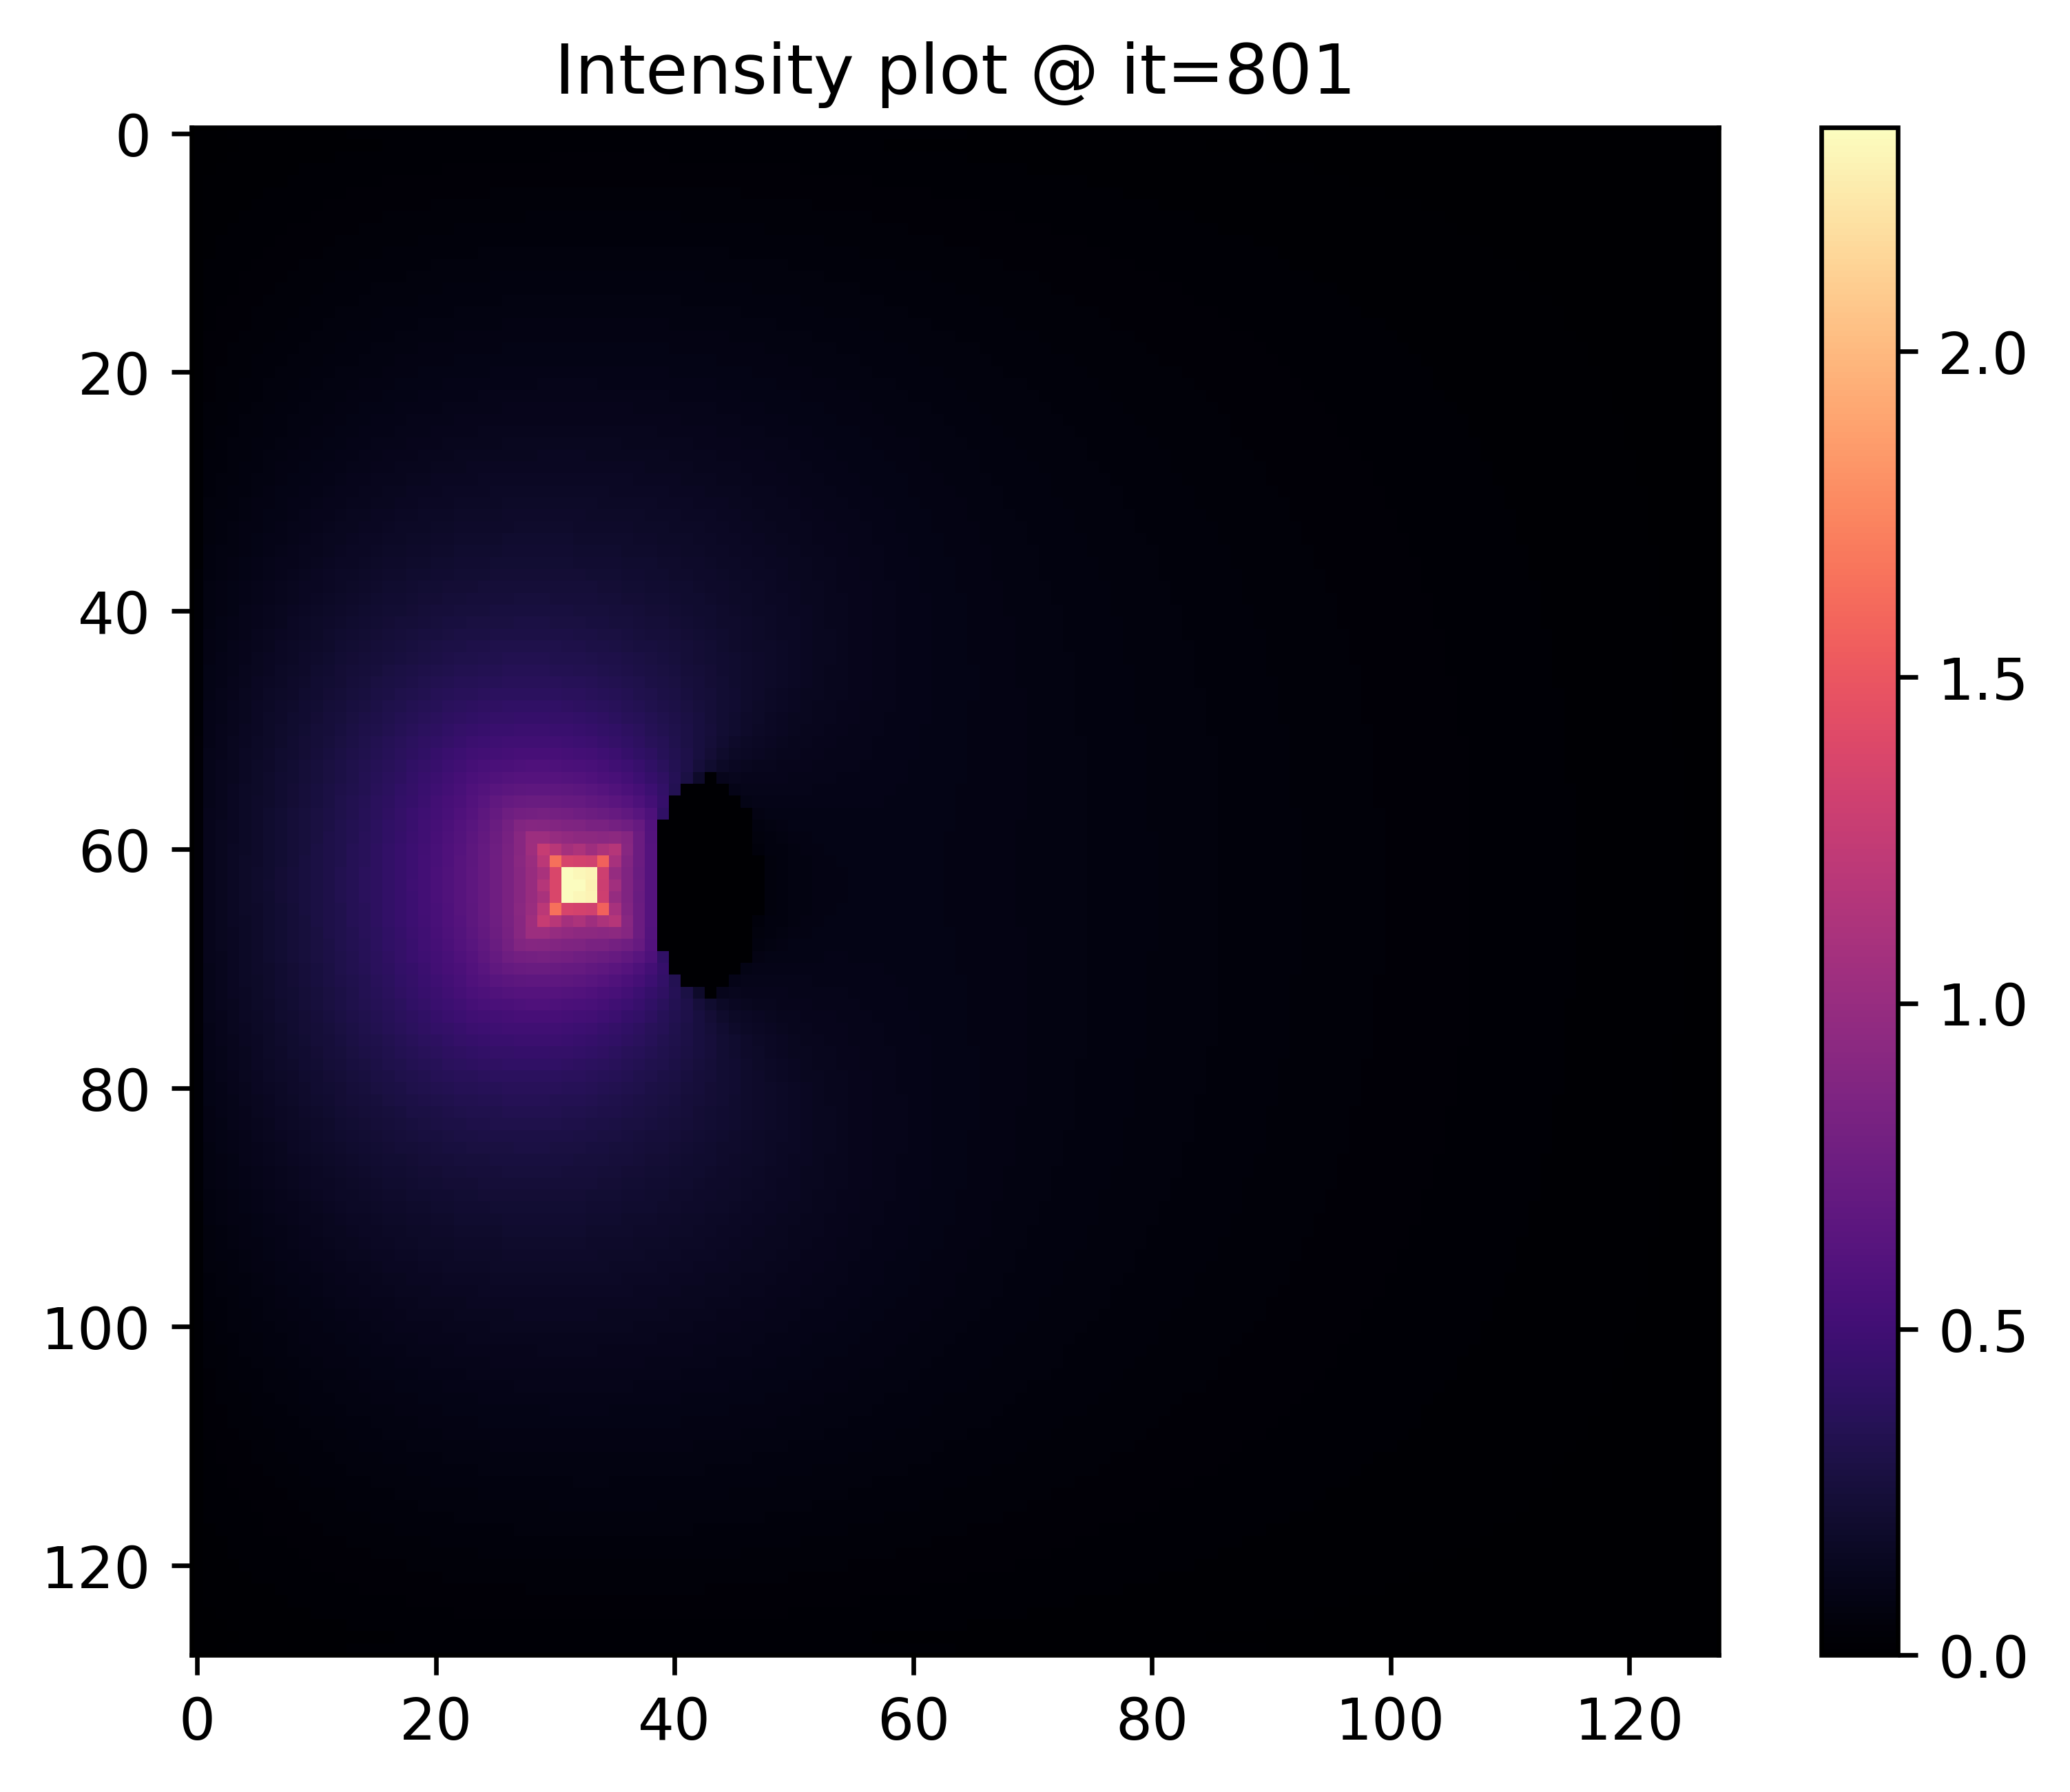

Completed simulation!


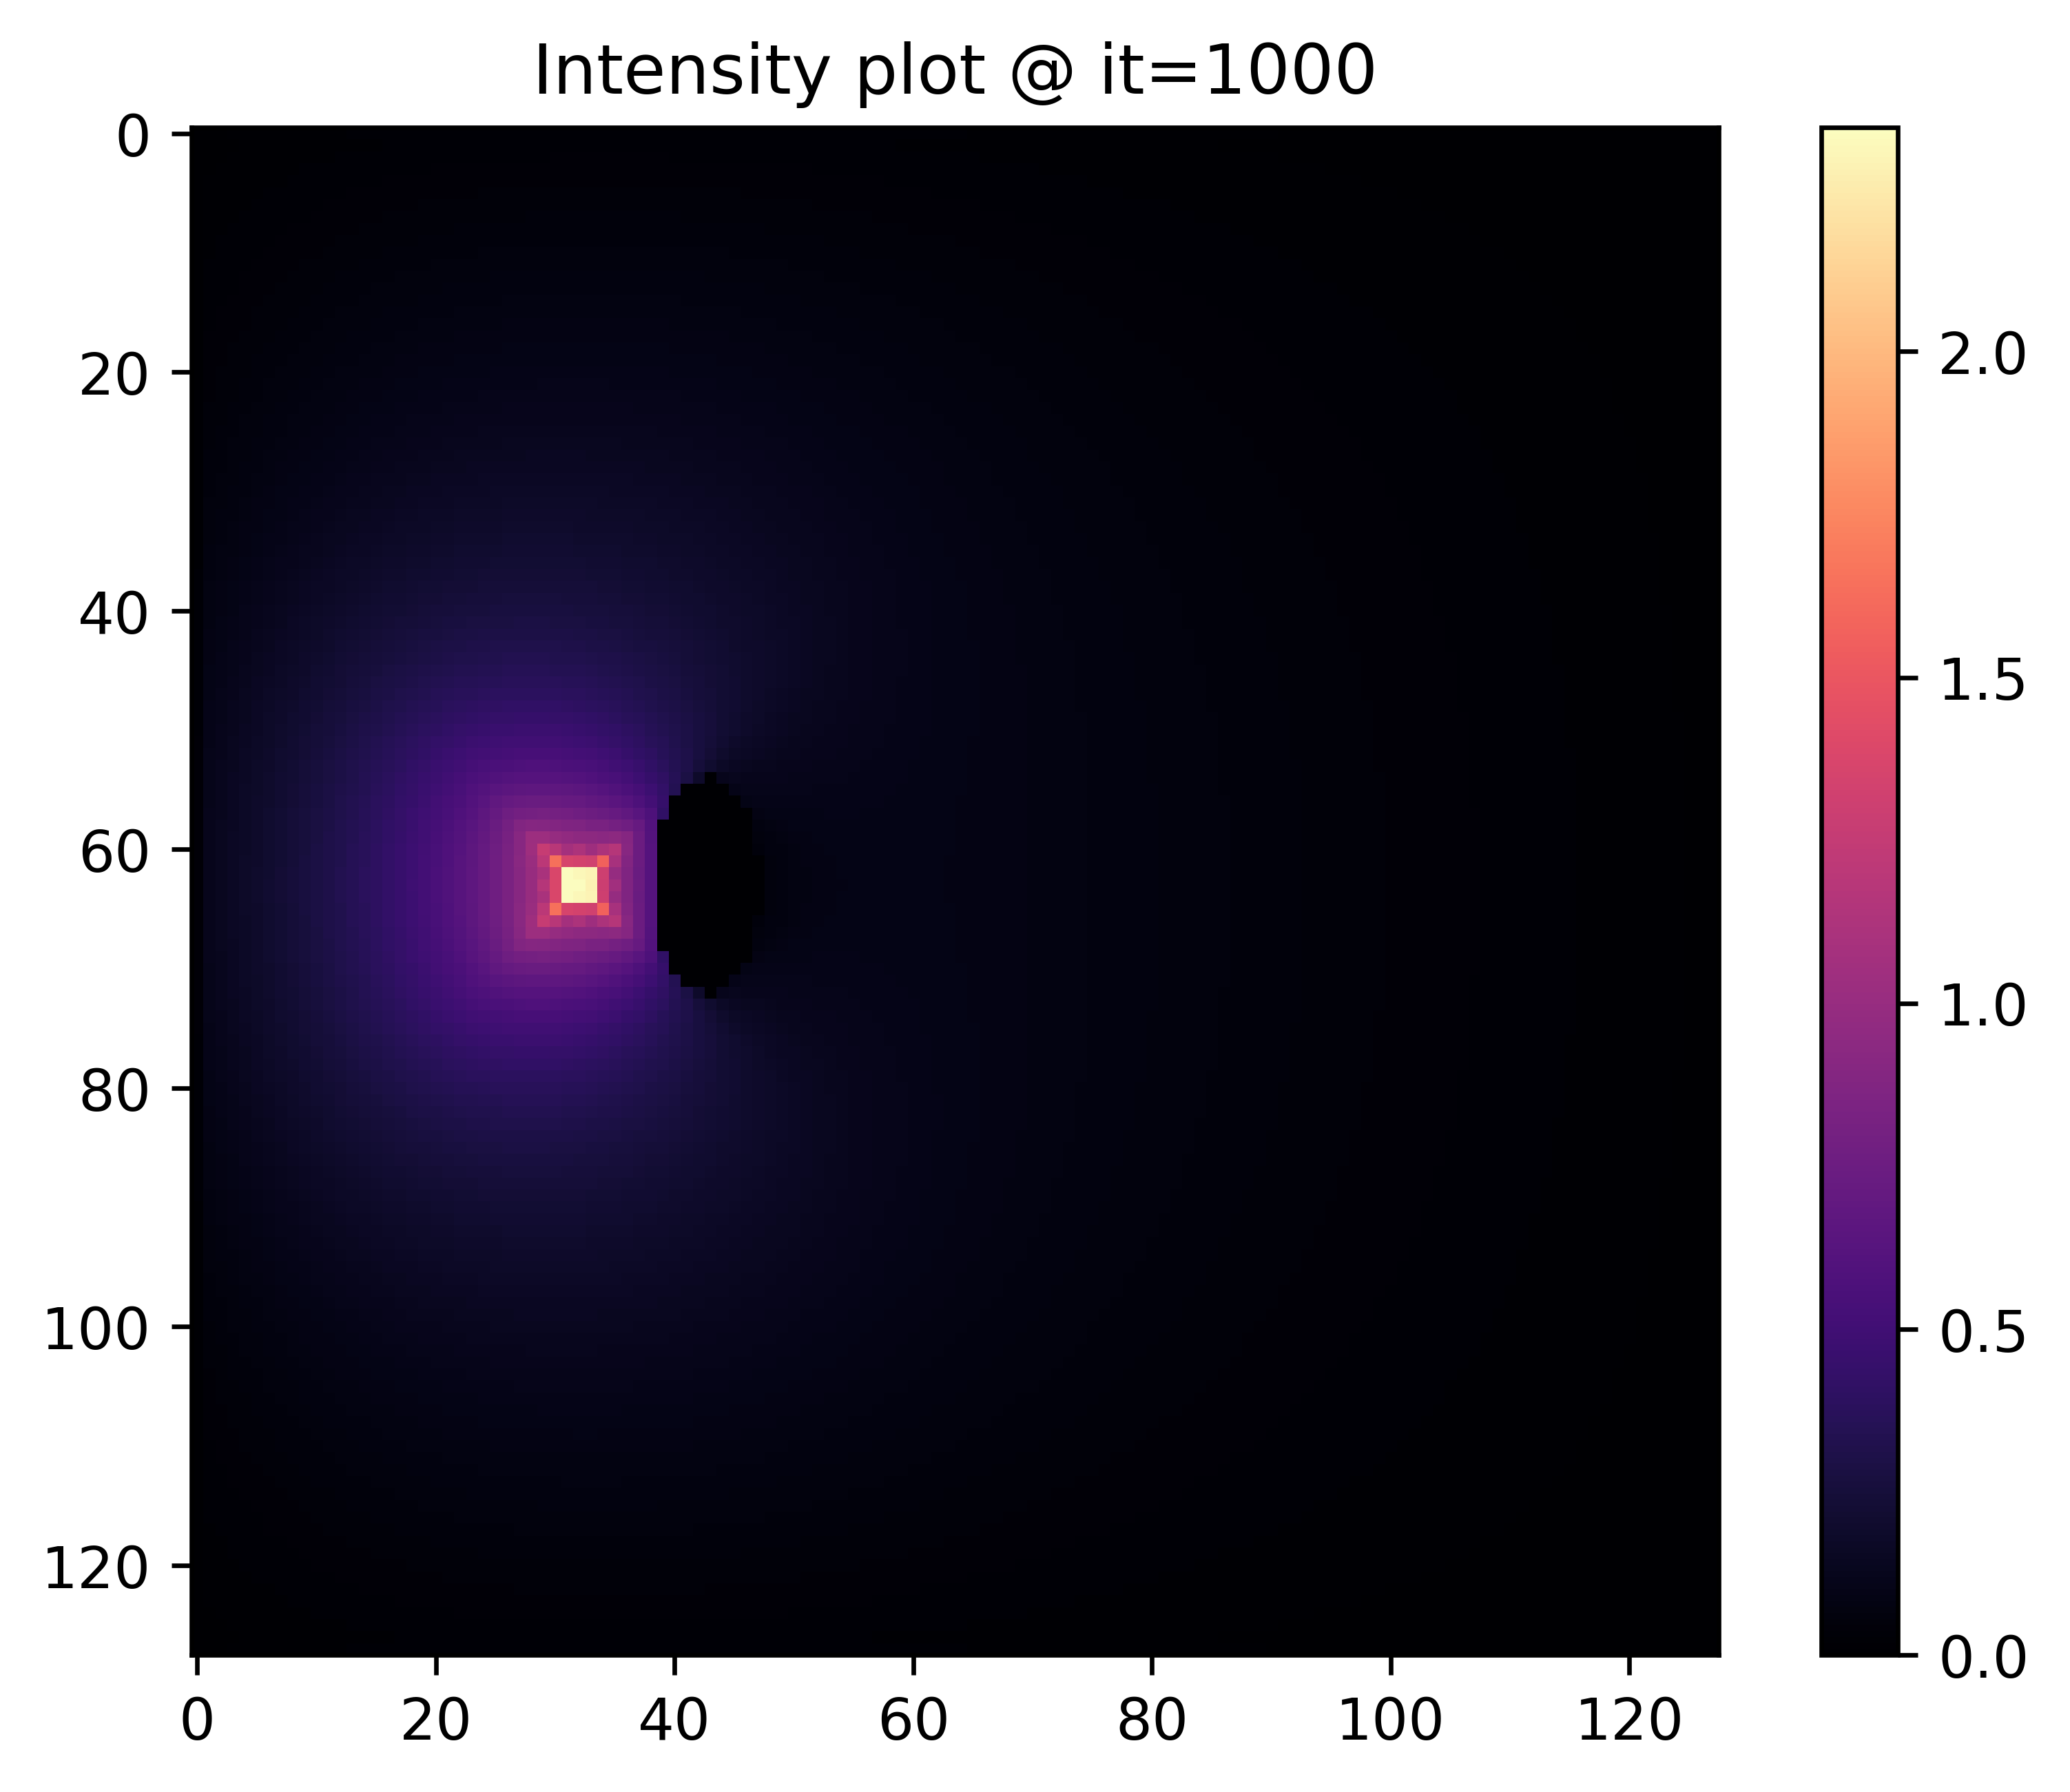

In [346]:
test = "shadow"

NX = 0
NY = 0
x0 = None
sources = []
number_density = 0.0
boundary_conditions = "periodic"

if test == "simple_sources":
    NX = 5
    NY = 5
    x0 = np.zeros((NY, NX, NL))
    
    # Simple test sources
    sources = [
        # ((NY//2, NX//2), [1] * 4 + [1] * 4), # D2Q8 # centered isotropic source
        # ((NY//2, NX//2), [1] * 1 + [0] * 7), # D2Q8 # centered unidirectional source
        # ((NY//2, NX//2), [0] * 4 + [1] * 1 + [0] * 3), # D2Q8 # centered unidirectional source
        # ((NY//2, NX-1), [1] * 1 + [0] * 7), # D2Q8 # unidirectional source at the edge
        # ((NY//2, NX//2), [1] * 16) # D2Q16 # centered isotropic source
        # ((NY-2, 3*NX//4), [1 if i in [7,14,15] else 0 for i in range(16)]) # D2Q16 # angled beam source at the edge
    ]
elif test == "corner_bcs":
    NX = 7
    NY = 7
    x0 = np.zeros((NY, NX, NL))

    # Corner BC tests
    if NL == 8:
        source_val = [0]*8
        source_val[4] = 1
        source = ((NY//2, NX//2), source_val)
        sources.append(source)
    elif NL == 16:
        source_val = [0]*16
        source_val[8] = 1
        source = ((NY//2, NX//2), source_val)
        sources.append(source)
elif test == "crb":
    # Crossing radiation beams test
    NX = 64
    NY = NX*4
    x0 = np.zeros((NY, NX, NL))
    
    sources = []

    # Beam half-waist
    j = int(1/2 * NX//3)

    beam_profile_linear = lambda jval, kval : jval - np.abs(kval)
    beam_profile_normal = lambda jval, kval : np.exp(-k**2)
    
    for k in range(-j, j+1):
        if NL == 8:
            sources.append(((NY-2, 1*NX//3+k), [0]*5 + [beam_profile_linear(j, k)]*1 + [0]*2))
            sources.append(((NY-2, 2*NX//3+k), [0]*4 + [beam_profile_linear(j, k)]*1 + [0]*3))
        elif NL == 16:
            sources.append(((NY-1, 1*NX//4+k), [0]*6 + [j-np.abs(k)]*1 + [0]*1 + [0]*8))
            sources.append(((NY-1, 3*NX//4+k), [0]*7 + [j-np.abs(k)]*1 + [0]*0 + [0]*8))
elif test == "shadow":
    # Shadow test
    NY = 128
    NX = NY
    H_min = 0
    H_max = NY
    boundary_conditions = [("dirichlet", 0)]*4

    # Option 1: Construct source on left wall
    if False:
        for j in range(NY):
            if NL == 8:
                lattice_vals = [0]*8
                # lattice_vals[0] = 1
                lattice_vals[4] = 1
                lattice_vals[7] = 1
                sources.append(((j, 0), lattice_vals))
            elif NL == 16:
                lattice_vals = [0]*16
                # lattice_vals[0] = 1
                lattice_vals[8] = 1
                lattice_vals[15] = 1
                sources.append(((j, 0), lattice_vals))
        
        # Construct opaque ellipse
        R = np.sqrt((NX**2+NY**2)/2)
        a = 0.05
        b = 0.1
        h = NX / 2
        k = NY / 2
    # Option 2: Isotropic source near left wall
    else:
        sources.append(((NY//2, 1*NX//4), [2] * NL))

        # Construct opaque ellipse
        R = np.sqrt((NX**2+NY**2)/4)
        a = 0.05
        b = 0.1
        h = NX / 3
        k = NY / 2
    
    X, Y = np.meshgrid(range(NX), range(NY))
    ellipse = ((X - h)/a) ** 2 + ((Y - k)/b) ** 2 < R**2
    number_density = np.zeros((NY, NX))
    number_density[ellipse] = 1
    plt.imshow(number_density)

# Simulate
print("Starting simulation...")
x = simulate(
    x0,
    NX, NY,
    sources=sources,
    number_density=number_density,
    redist_coeff=0.5,
    boundary_conditions=boundary_conditions,
    n_it=1000,
    plotRealTime=True,
    plotLattViz=False,
    plot_period=0.2,
    color_opacity=False
)
print("Completed simulation!")

85.61698213887729 1615 0.053013611231502965
1497.9653870117377 14769 0.10142632453190721


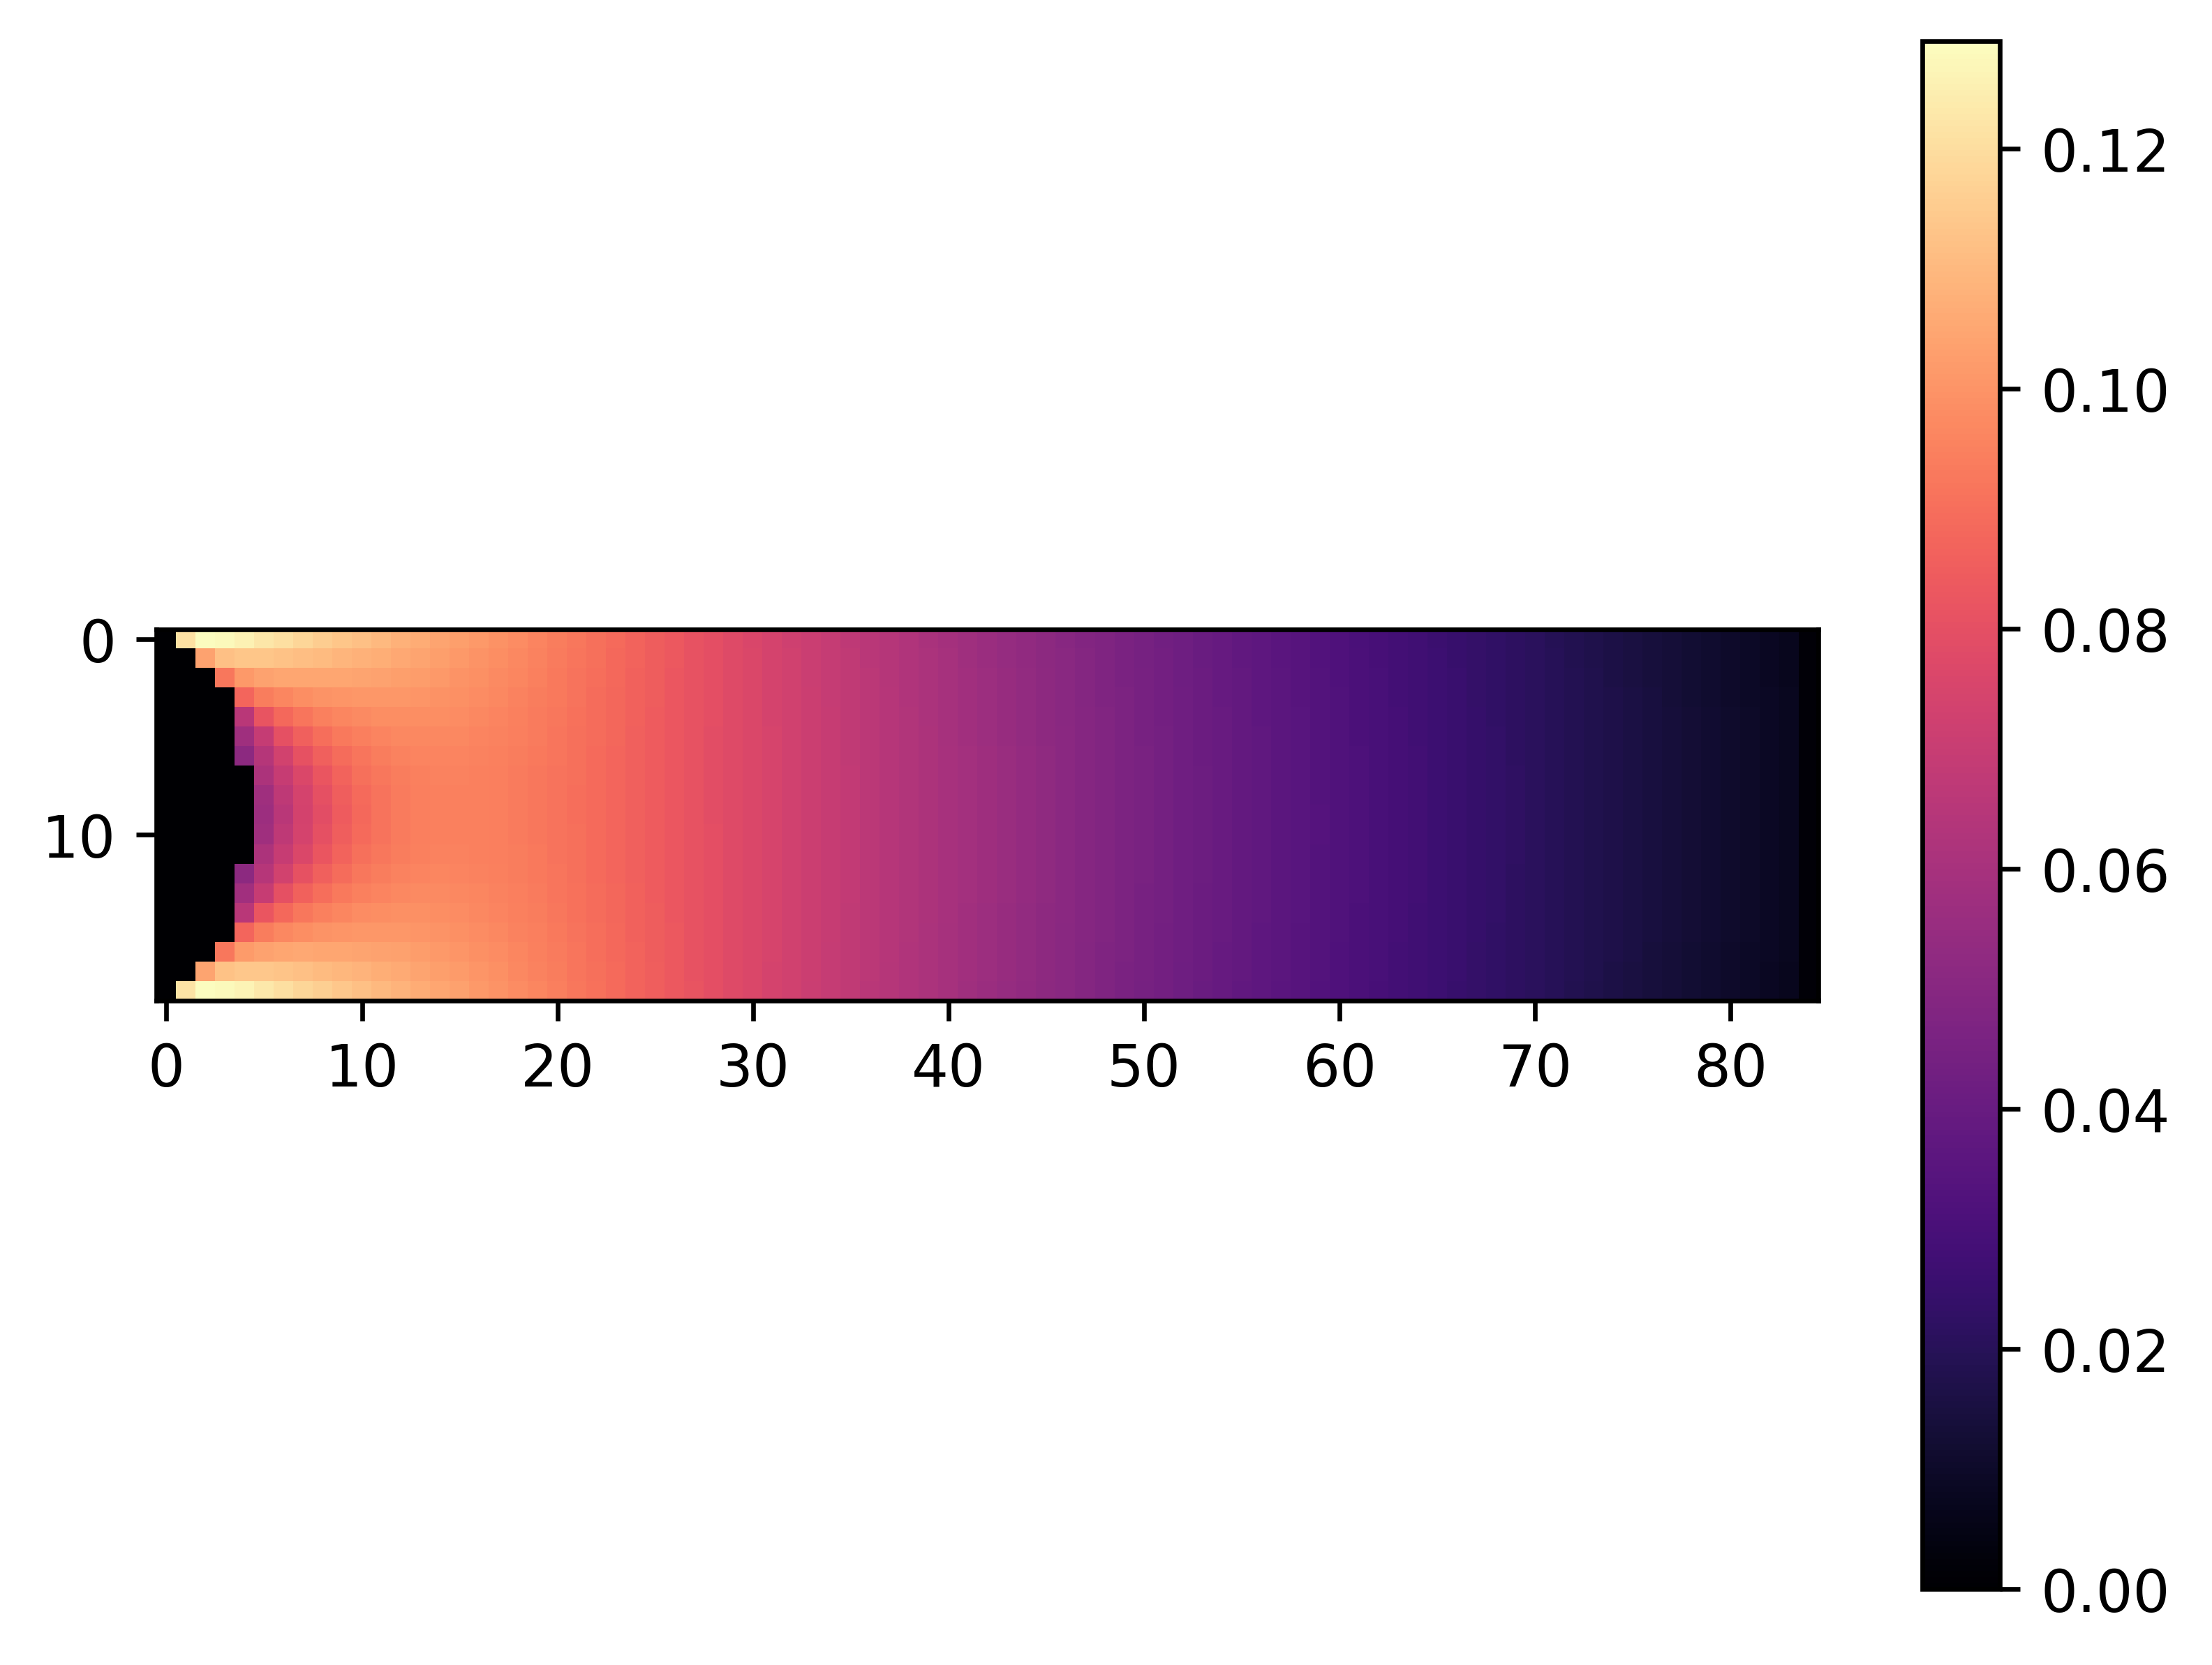

In [347]:
ldraw = np.sum(np.copy(x), axis=2)
# ldraw += -1*number_density
ldraw = ldraw[NY//2-9:NY//2+9+1, 43:]
# ldraw = ldraw[NY//2-16:NY//2+16+1, NX//2-30+10:NX//2+15+10+1]
ldraw = ldraw[::-1, :]
plt.imshow(ldraw, cmap="magma")
plt.colorbar()

print(np.sum(ldraw), ldraw.size, np.sum(ldraw)/ldraw.size)

nodraw_sum = np.sum(x[:, :43]) + np.sum(x[:NY//2-9, 43:]) + np.sum(x[NY//2+9+1:, 43:])
nodraw_size = np.sum(x, axis=2).size - ldraw.size
print(nodraw_sum, nodraw_size, nodraw_sum/nodraw_size)

# Visualization

In [10]:
from PIL import Image
import os

# If save_lattviz=True, then we can convert the saved PNGs to a GIF
def pngs_to_gif(folder_path, output_gif, duration=500):
    images = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith(".png"):
            img_path = os.path.join(folder_path, file)
            images.append(Image.open(img_path).convert("RGBA"))

    if images:
        images[0].save(
            output_gif,
            save_all=True,
            append_images=images[1:],
            duration=duration,
            loop=0
        )
        print(f"GIF saved as {output_gif}")
    else:
        print("No PNG files found in the folder.")

# Example usage
folder = "./lattviz_frames"
output = f"./movies/lattviz.gif"
pngs_to_gif(folder, output, duration=1000)

GIF saved as ./movies/lattviz.gif


In [41]:
# CLI-based utility with some other capabilities
# !convert -limit memory 2GiB -loop 0 -layers optimize -resize 1000 -delay 50 './frames/*.png' './frames/output.gif'
!convert -limit memory 2GiB -loop 0 -layers optimize -resize 1000 -delay 50 './lattviz_frames/*.png' './movies/output.gif'

/tmp/ipykernel_19989/4021267980.py:20: RuntimeWarning: divide by zero encountered in log10
  cax = plt.imshow(np.log10(X), cmap="magma")


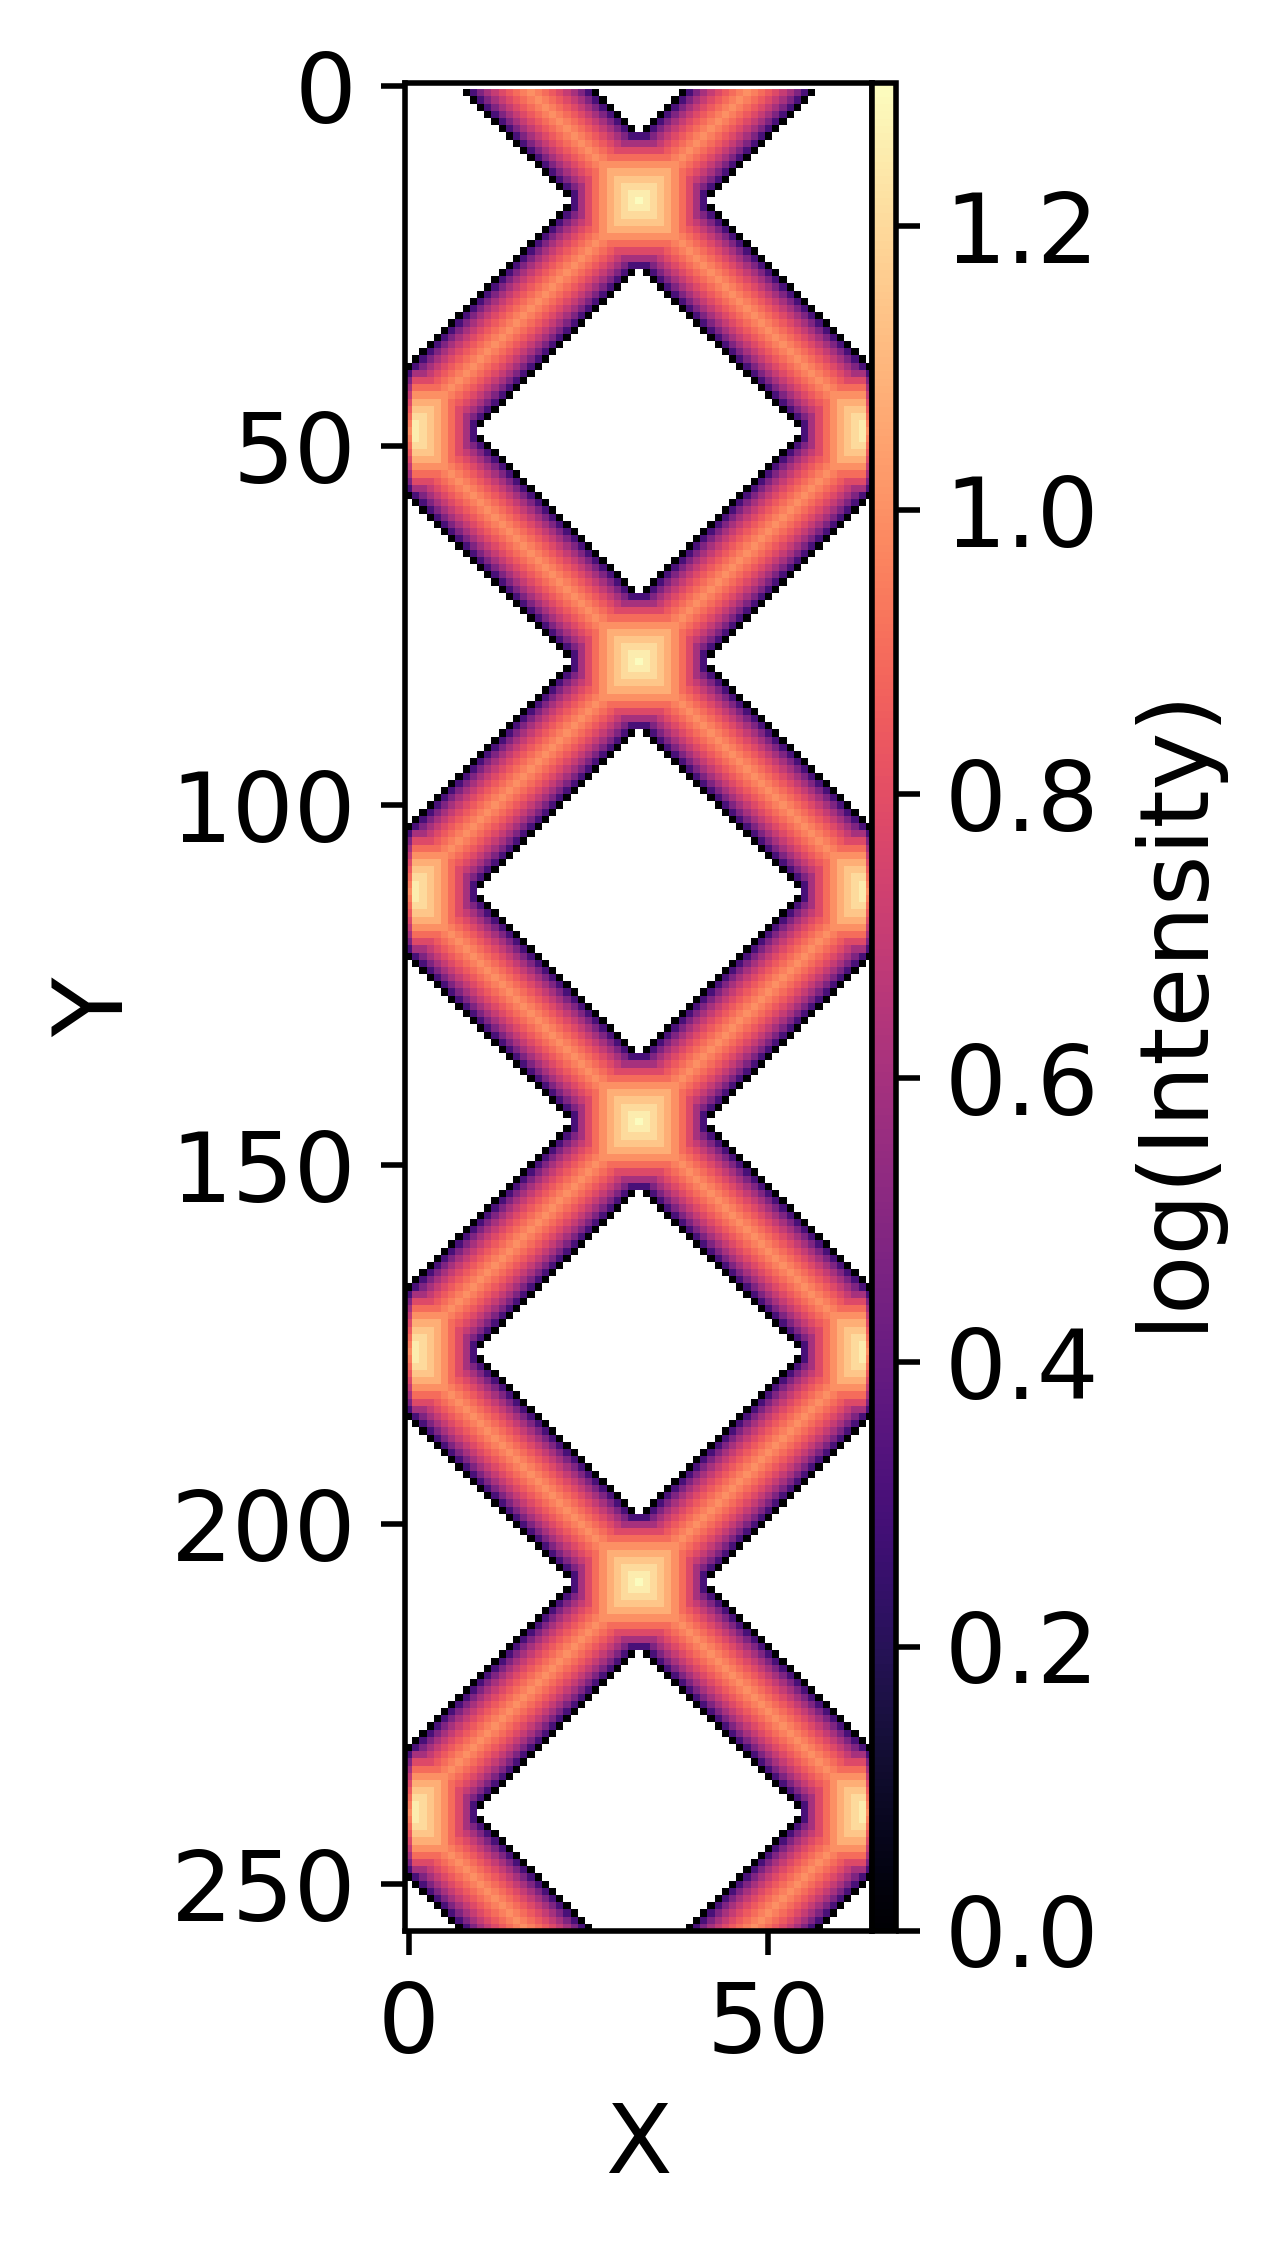

In [47]:
# Plot a zoom-in of the grid
def plot_zoom(scale="normalized"):
    fig, ax = plt.subplots()
    
    X = np.sum(x, axis=2) # full
    
    # X = np.sum(x[:NY//2+1, NX//2:], axis=2) # top-right corner
    # X = np.sum(x[3*N//4:, :N//4], axis=2) # bottom-left corner
    
    # X = np.sum(x[1*NY//4+1:3*NY//4, 1*NX//4+1:3*NX//4], axis=2) # center half
    # X = np.sum(x[3*NY//8:5*NY//8+1, 3*NX//8:5*NX//8+1], axis=2) # center fourth
    # X = np.sum(x[3*NY//8:4*NY//8, 4*NX//8:5*NX//8], axis=2) # center top-left corner
    # X = np.sum(x[3*NY//8:4*NY//8, 4*NX//8:5*NX//8], axis=2) # center top-right corner
    
    # print(X)

    if scale == "normalized":
        cax = plt.imshow(X/np.max(X), cmap="magma")
        label = "Normalized intensity"
    elif scale == "log10":
        cax = plt.imshow(np.log10(X), cmap="magma")
        label = "log(Intensity)"
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    divider = make_axes_locatable(ax)
    cbaxes = divider.append_axes("right", size="5%", pad=0.0)  # Adjust pad to 0 for no gap
    cb = fig.colorbar(cax, cax=cbaxes, label=label)
    
    ax.set_aspect(1)
    plt.gcf().set_dpi(500)
    
    plt.rcParams.update({'font.size': 14})
    
    plt.savefig("crb.png", dpi=500)

plot_zoom("log10")

(10, 10, 8)


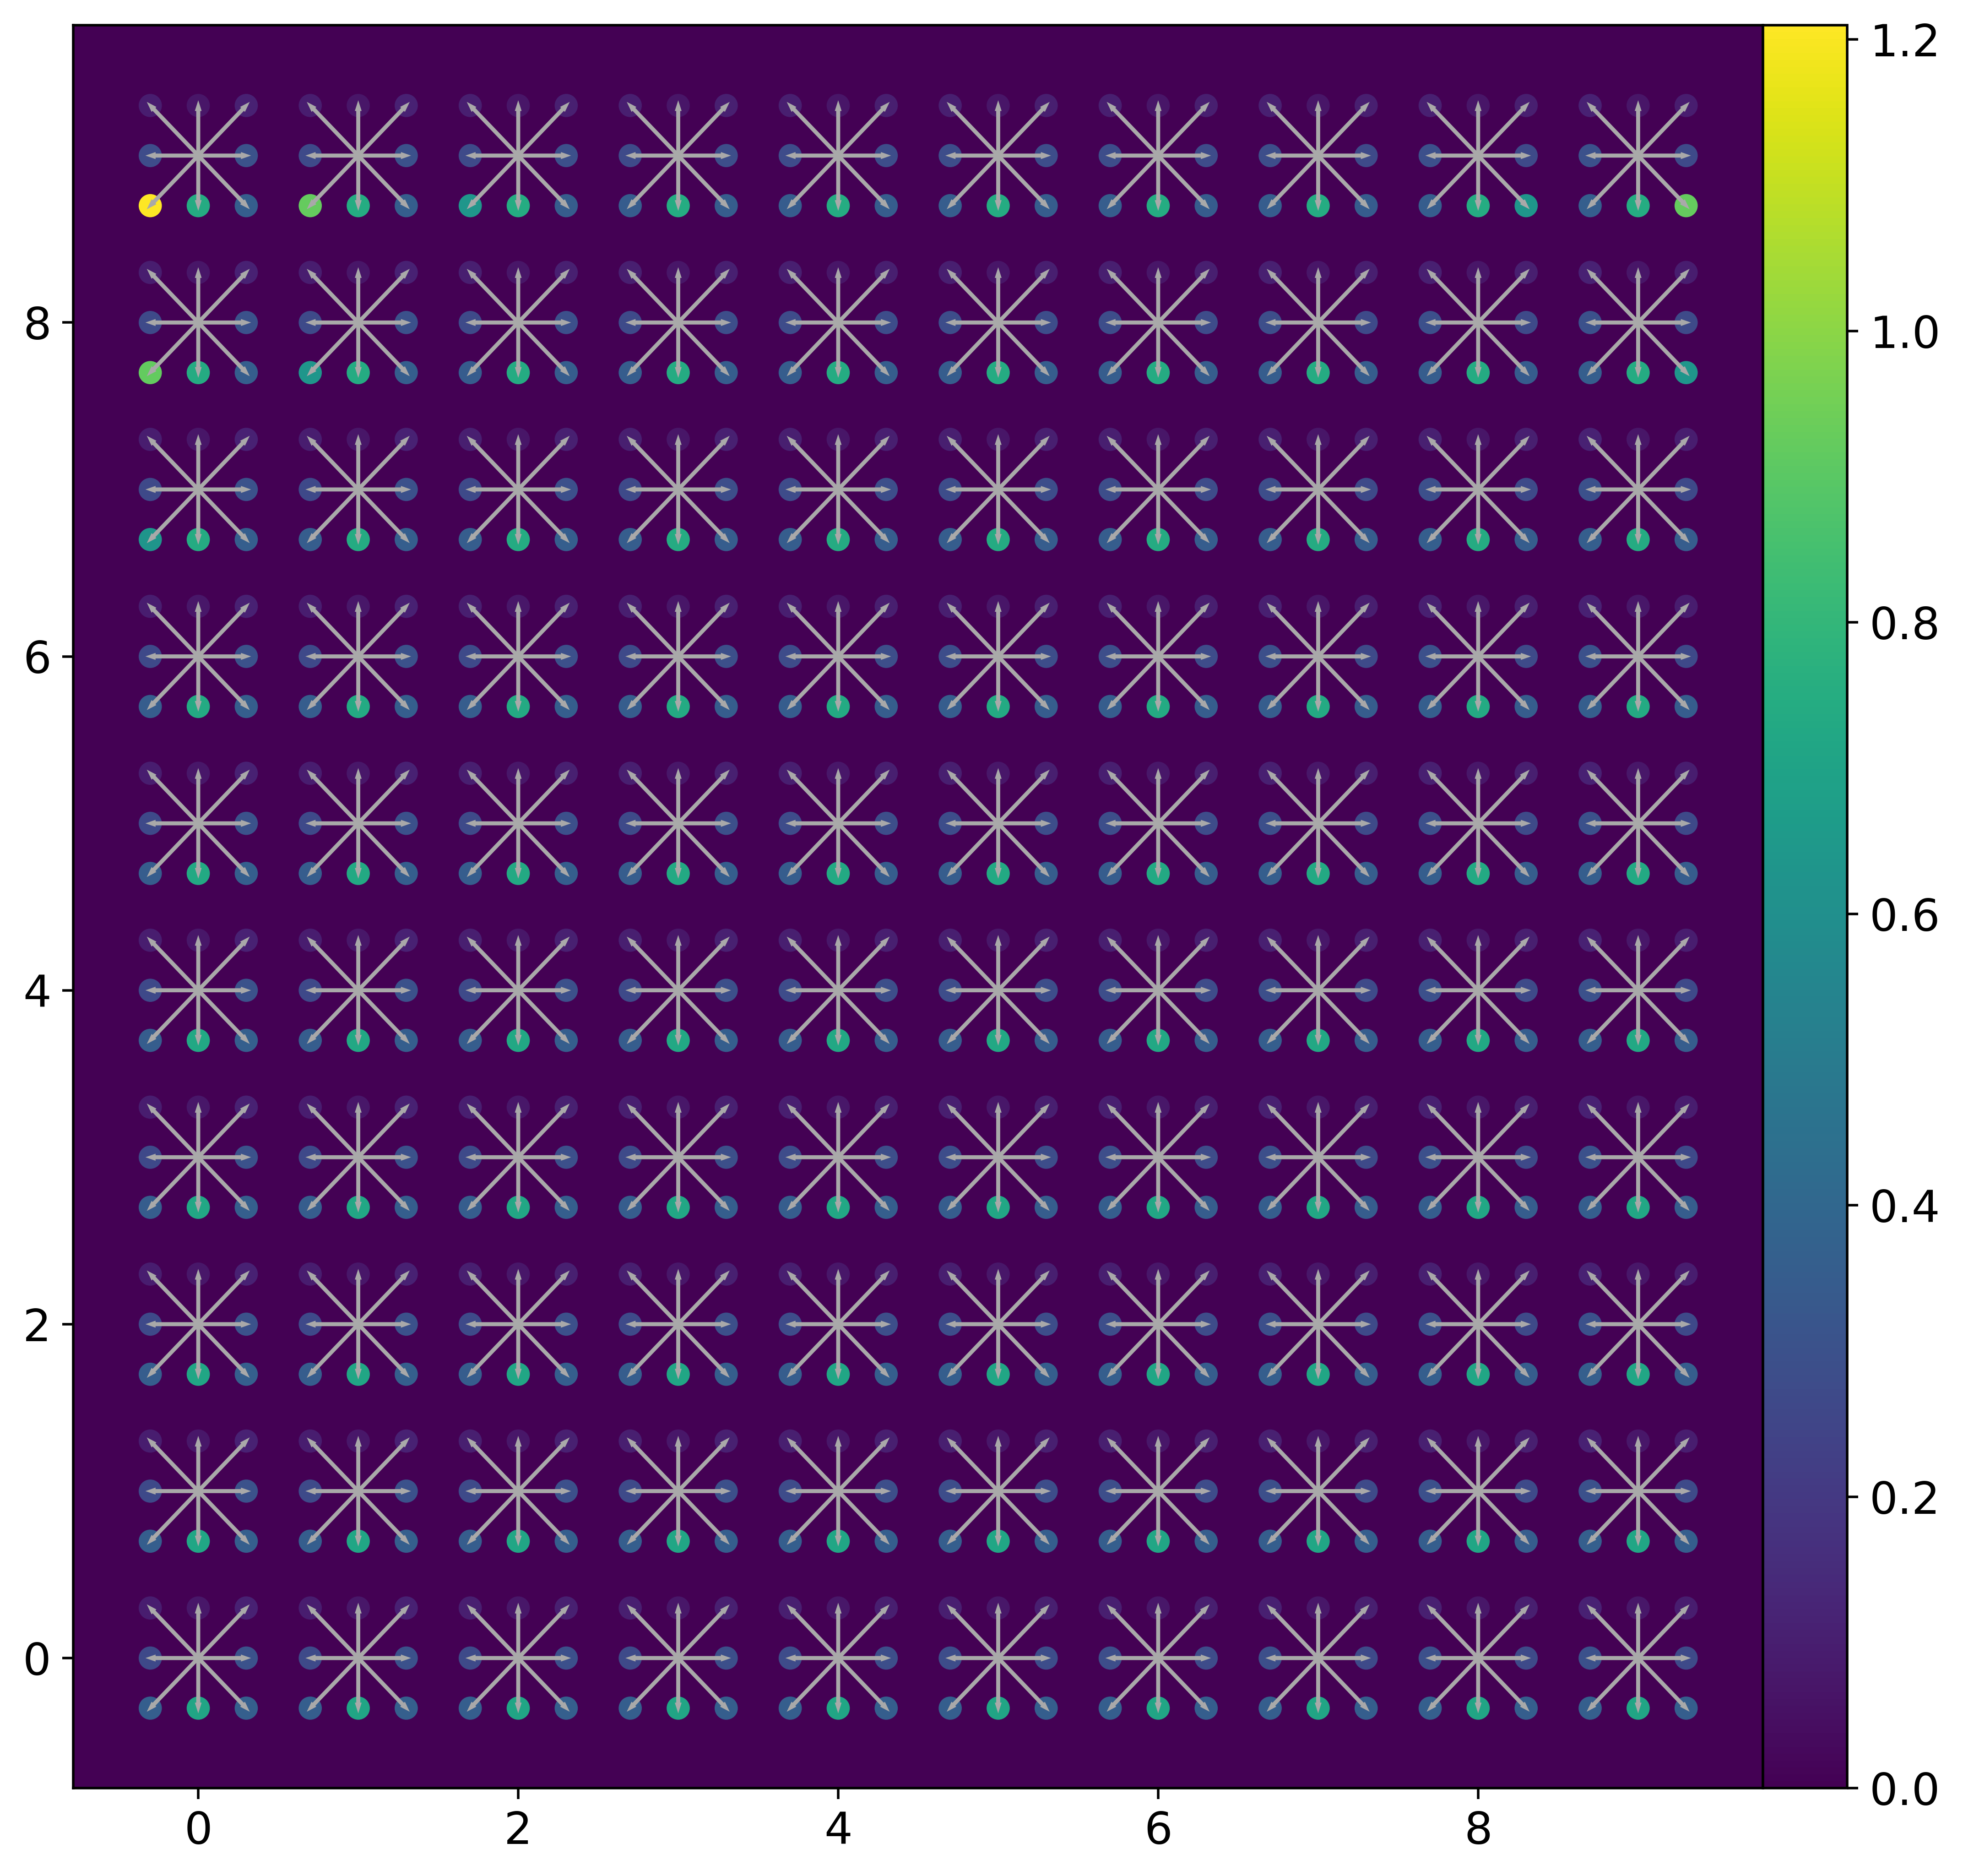

In [23]:
# Plot the expanded lattice using lattviz.draw_lattice_2d

# We can do zoom-ins here too
# lattice = x[3*NY//8+1:5*NY//8, 3*NX//8+1:5*NX//8] # center fourth

Y_c = NY//2
X_c = NX//2
lattice = x[Y_c-5:Y_c+5, X_c-5:X_c+5] # center 10x10 grid

print(lattice.shape)
draw_lattice_2d(lattice, cxs, cys)

### Save simulation lattices

In [42]:
np.save("./data/redistribution_data.npy", x)
assert np.allclose(x, np.load("./data/redistribution_data.npy"))

### Load latest simulation lattices

In [1]:
x = np.load("./data/redistribution_data.npy")

NameError: name 'np' is not defined

# Data analysis

### Intensity along +x-axis

(33,)
[-3.27026504  3.15128052]


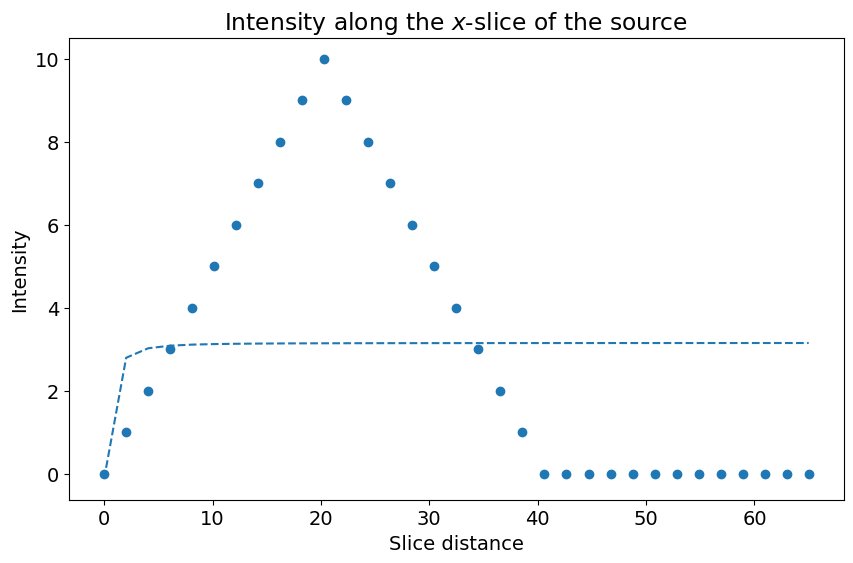

In [44]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot simulation results
intensity_slice = np.sum(x, axis=2)[sources[0][0][1], NX//2:NX]
# intensity_slice = np.flipud(np.sum(x, axis=2)).diagonal()[NX//2:]
print(intensity_slice.shape)

coordinate_slice = np.linspace(0, NX, intensity_slice.size)

plt.scatter(coordinate_slice, intensity_slice)

# Perform fit
i_start = 0
i_stop = len(intensity_slice)

fit_func = inverse_square_bg

fit_params, _ = curve_fit(fit_func, coordinate_slice[i_start:i_stop]+1, intensity_slice[i_start:i_stop])
print(fit_params)

fit_intensity_slice = fit_func(coordinate_slice+1, *fit_params)
plt.plot(coordinate_slice, fit_intensity_slice, "--")

plt.title("Intensity along the $x$-slice of the source")

ax.set_xlabel("Slice distance")
ax.set_ylabel("Intensity")

plt.savefig("./plots/redistribution_slice.png", dpi=500)
plt.show()

### Data processing for radial profile

In [27]:
# manual 2D radial profile plot
slice_r = []
slice_I = []

hx = sources[0][0][0]
hy = sources[0][0][1]
hz = 0

N = np.sqrt(NX**2 + NY**2 + 0**2)

k = 0 # we select the slice z = 0
for i in range(NX):
    for j in range(NY):
        r = np.sqrt((i-hx)**2 + (hy-j)**2 + (k-hz)**2)
        slice_r.append(r/N)
        slice_I.append(np.sum(x[j, i]))
        
        # print(r, (x, y, z), intensity_slice[x, y].value)

slice_I_norm = slice_I / np.max(slice_I) # normalize intensities - can sometimes help (or hurt) fitting

### Radial intensity profile

[-4.30616807  5.61770479]


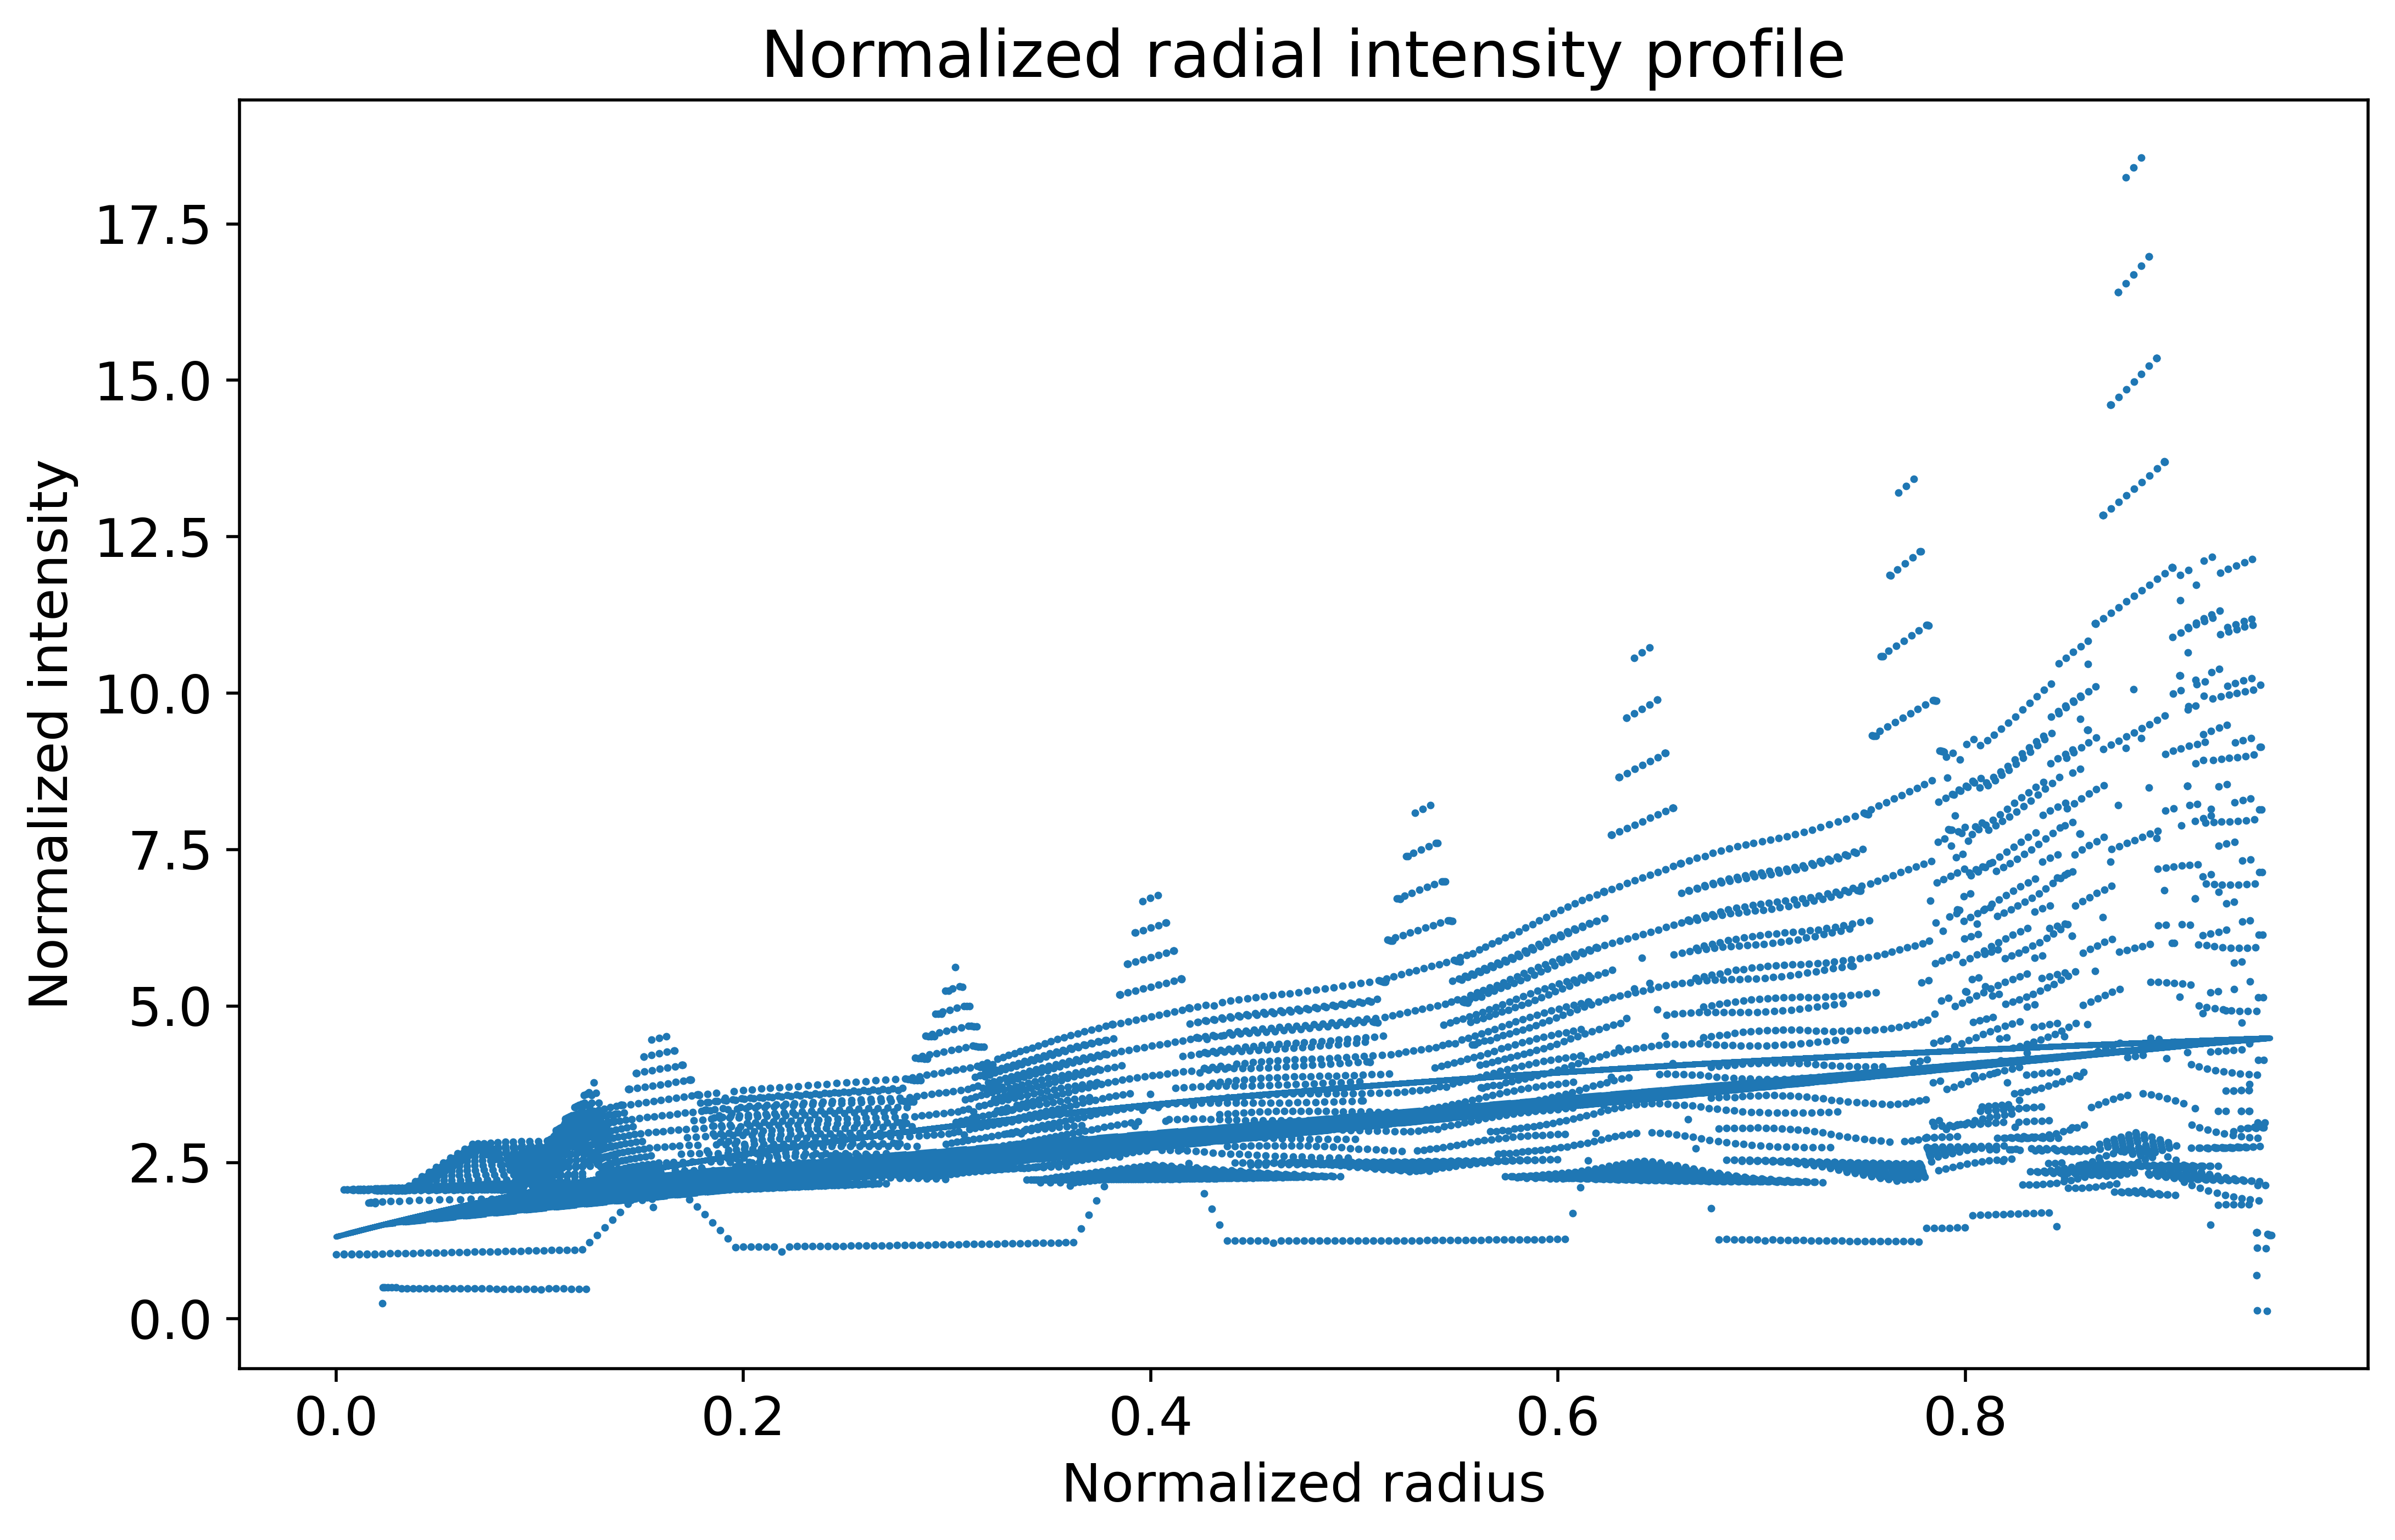

In [28]:
# i_start = 0
i_stop = int(len(slice_r) * 0.5)

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(slice_r[i_start:i_stop], slice_I[i_start:i_stop], s=1)

fit_func = inverse_square_bg

fit_params, _ = curve_fit(fit_func, np.array(slice_r[i_start:i_stop])+1, slice_I[i_start:i_stop])
print(fit_params)

fit_slice_I = fit_func(np.array(slice_r[i_start:i_stop])+1, *fit_params)
# fit_slice_I = fit_func(np.array(slice_r[i_start:i_stop])+1, 2)
plt.plot(slice_r[i_start:i_stop], fit_slice_I[i_start:i_stop], "--")

np.savetxt("./data/normalized_radial_intensities.csv", slice_I, delimiter=",")

plt.title("Normalized radial intensity profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Normalized intensity")

plt.gcf().set_dpi(500)

plt.savefig("./plots/redistribution_radial_profile.png", dpi=1000)
plt.show()

### Data processing for mean radial profile

In [29]:
slice_r_groups = {}

for r, I in zip(slice_r, slice_I):
    if r in slice_r_groups:
        slice_r_groups[r].append(I)
    else:
        slice_r_groups[r] = [I]

slice_r_values = []
slice_I_means = []
slice_I_stdevs = []
for r, I_list in slice_r_groups.items():
    slice_r_values.append(r)
    slice_I_means.append(np.mean(I_list))
    slice_I_stdevs.append(np.std(I_list))

slice_I_means = np.array(slice_I_means)
slice_I_stdevs = np.array(slice_I_stdevs)

print(np.shape(slice_r_values), np.shape(slice_I_means), np.shape(slice_I_stdevs))
print(np.std(slice_I), np.mean(slice_I_stdevs))

(11145,) (11145,) (11145,)
1.9965937801706557 0.2125112961974135


In [30]:
# Simultaneously sort both the radii and intensities
z = zip(slice_r_values, slice_I_means)
zs = sorted(z)
u = zip(*zs)
slice_r_values, slice_I_means = map(list, u)
slice_r_values, slice_I_means = np.array(slice_r_values), np.array(slice_I_means)

### Mean radial profile

[3.1086419]


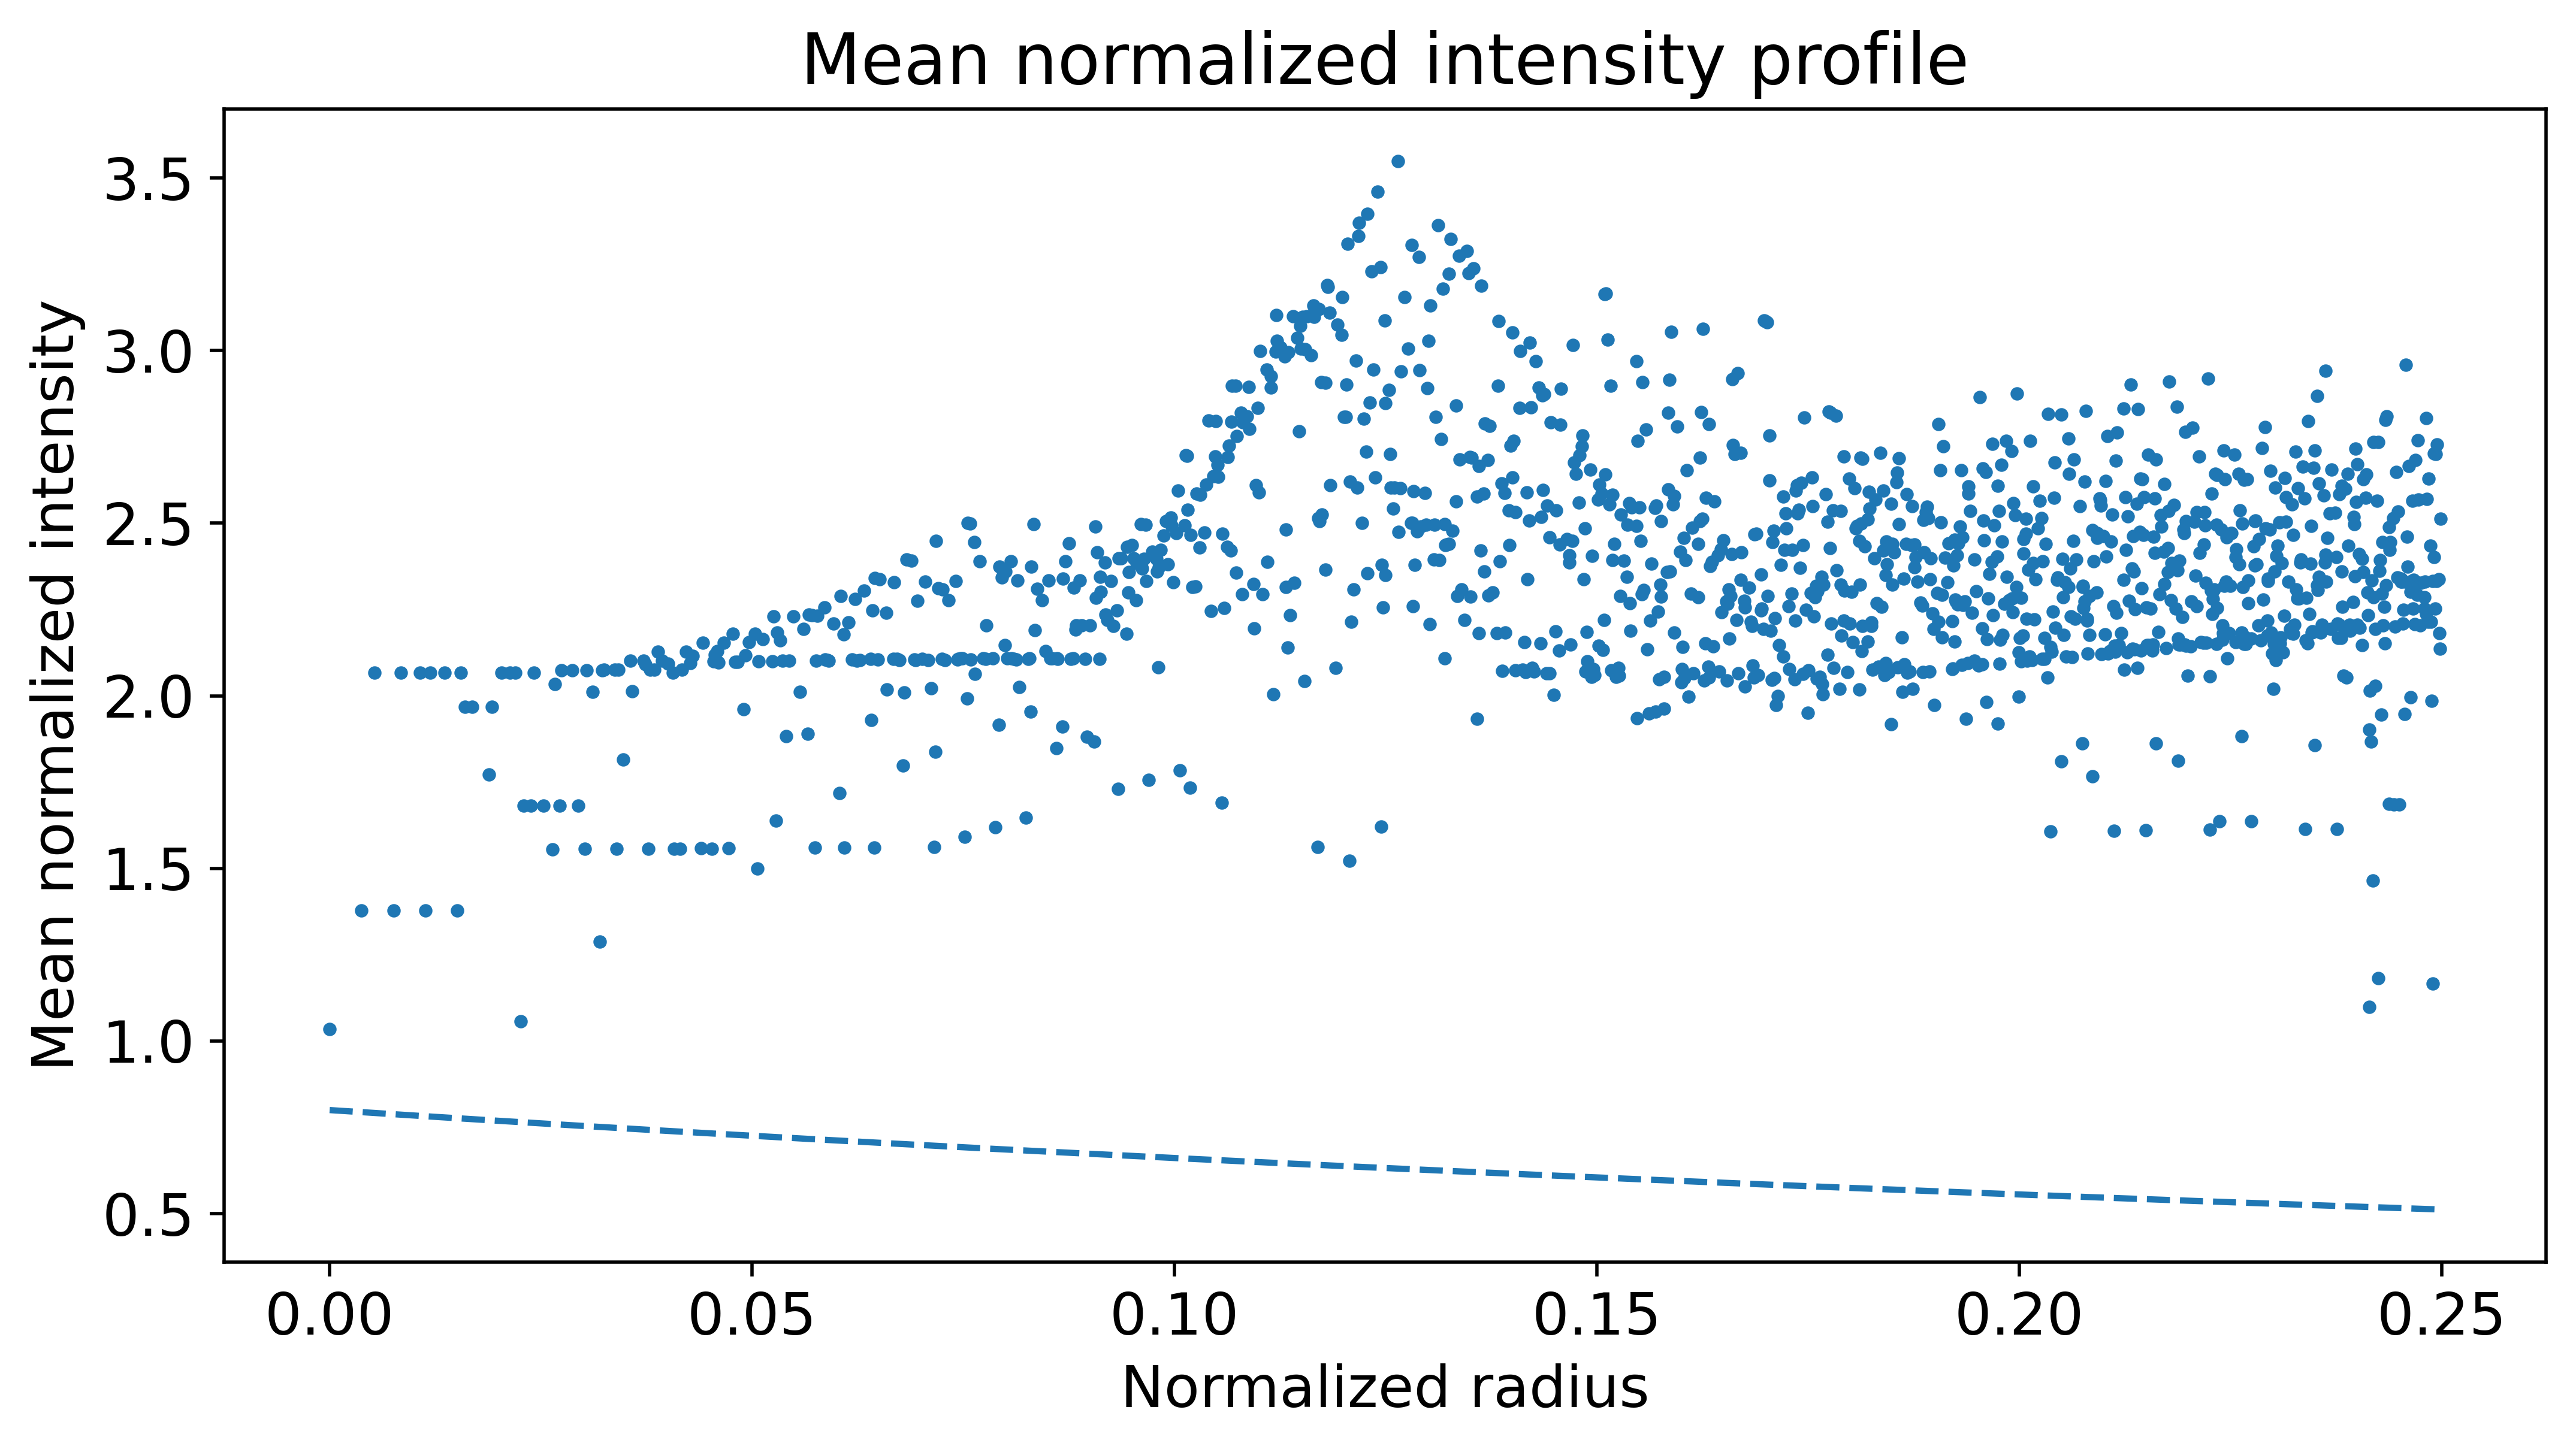

In [31]:
fig, ax = plt.subplots(figsize=(10,5))

x_mask = np.argwhere(slice_r_values <= 0.25)
xlim = np.max(x_mask)
# xlim = np.min(np.argwhere(slice_I_means <= 1E-2))

i_start = 0
i_stop = min(xlim, len(slice_I_means))

plt.scatter(slice_r_values[i_start:i_stop], slice_I_means[i_start:i_stop], s=5)

# Perform fit
fit_func = inverse_square

fit_params, _ = curve_fit(fit_func, slice_r_values[i_start:i_stop]+1, slice_I_means[i_start:i_stop])
print(fit_params)

# fit_intensity_slice = fit_func(slice_r_values+1, *fit_params)
fit_intensity_slice = fit_func(slice_r_values+1, 0.8)
plt.plot(slice_r_values[i_start:i_stop], fit_intensity_slice[i_start:i_stop], "--")

plt.title("Mean normalized intensity profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Mean normalized intensity")

plt.gcf().set_dpi(500)

plt.savefig("./plots/redistribution_mean_radial_profile.png", dpi=1000)
plt.show()

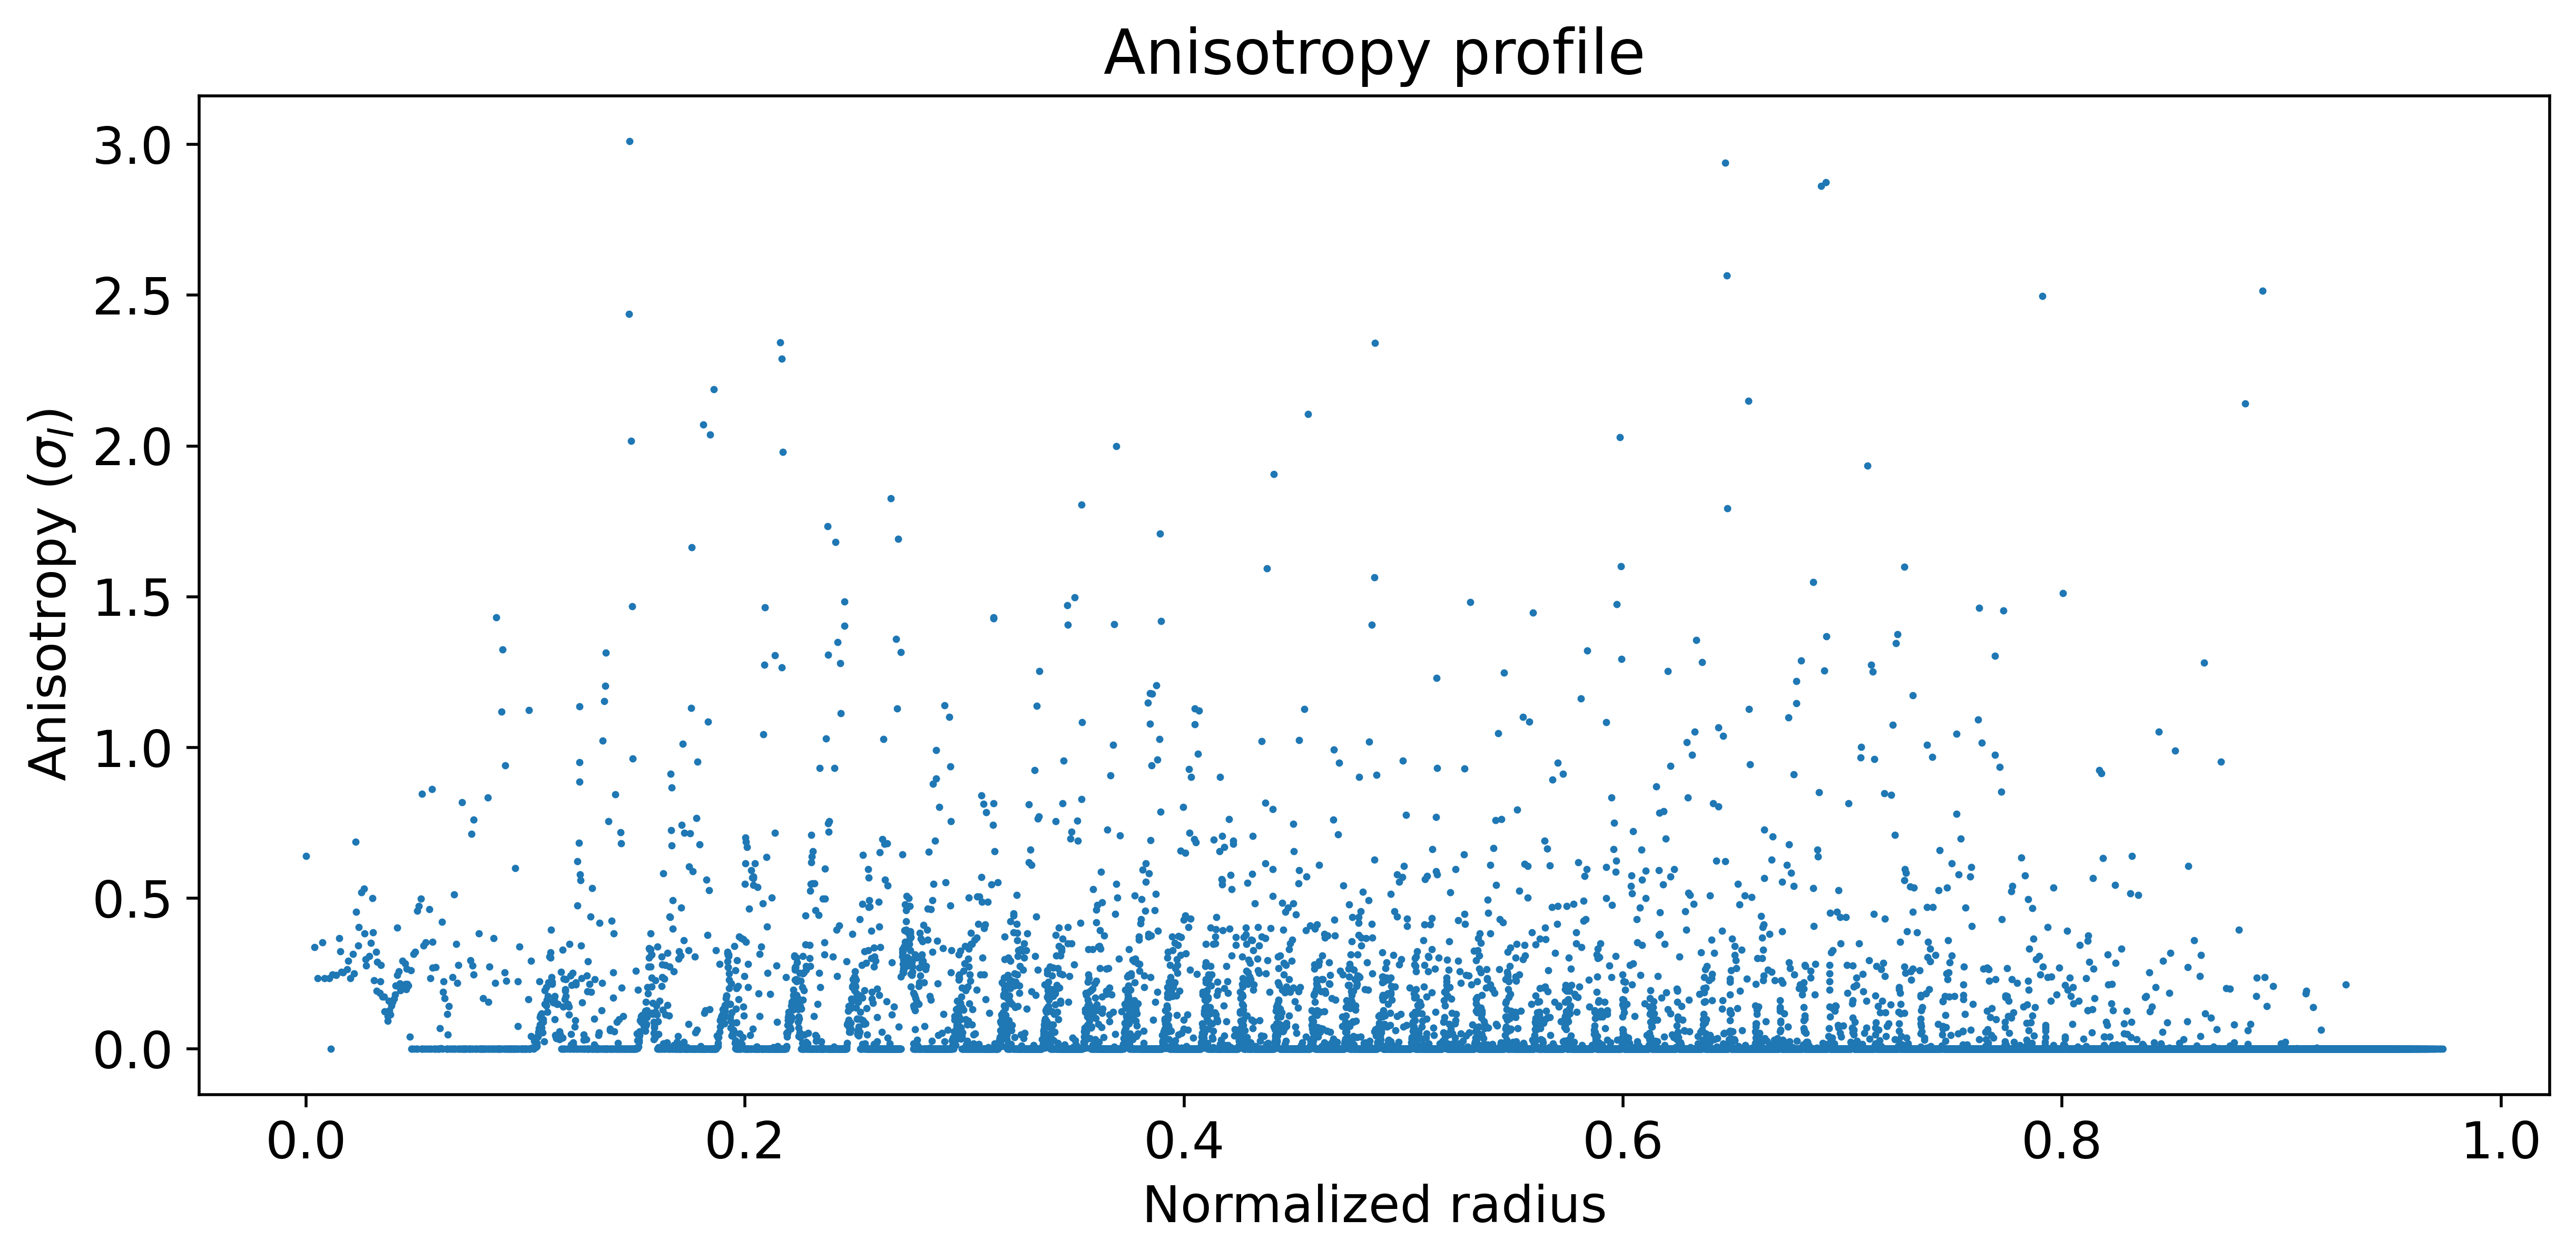

In [32]:
# @TODO - Test other measures of anisotropy (why isn't relative error working?)
fig, ax = plt.subplots(figsize=(10,5))

xlim = int(len(slice_r_values) * 1.0)

# plt.scatter(slice_r_values[:xlim], slice_I_stdevs[:xlim], s=5)
plt.scatter(slice_r_values, slice_I_stdevs/slice_I_means, s=1)

plt.title("Anisotropy profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Anisotropy ($\\sigma_I$)")

plt.gcf().set_dpi(500)
plt.tight_layout()

plt.savefig("./plots/redistribution_anisotropy.png", dpi=1000)
plt.show()